# Comparing virtual particle trajectories from ocean-only (uncoupled) and ocean-wave (coupled) model simulations for the Mediterranean Sea

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import ticker
from matplotlib import colors
from matplotlib.offsetbox import AnchoredText
from matplotlib import cm
import xarray as xr
import numpy as np
from xhistogram.xarray import histogram
import os.path
from datetime import timedelta, datetime
from glob import glob


In [2]:
col_blue = (68/255,119/255,170/255)
col_cyan = (102/255,204/255,238/255)
col_green = (34/255,136/255,51/255)
col_yellow = (204/255,187/255,68/255)
col_red = (238/255,102/255,119/255)
col_purple = (170/255,51/255,119/255)
col_grey = (187/255, 187/255, 187/255)

## 1. Loading and format trajectory data

In [3]:
############################

# set zarrdata to False if Parcels_CalcTraj.ipynb has not been executed
## then the trajectory data in netcdf format will be loaded
zarrdata = True

datapath = '/Users/siren/IMMERSE_waves/develop-mac/data/Trajectories-revisedNEMO/GulfOfLion/'

gridpath = '/Users/siren/Data/IMMERSE/domain/mesh_mask.nc'

############################


# Trajectories

tonetcdf = False # set to True if you want to save trajectory data in netcdf format

if zarrdata==True:
    trajpaths_csd = sorted(glob(f'{datapath}Parcels_CalcTraj_Data-coupled-sd_Release-GulfOfLion-t*_Integrate-fw-d30-dt25m_Sample-UV.zarr/'),
                          key=lambda f: int(''.join(filter(str.isdigit, f))))
    traj_csd = xr.open_mfdataset(trajpaths_csd,
                                 concat_dim="start", combine="nested",
                                 engine="zarr")
    
    trajpaths_cnosd = sorted(glob(f'{datapath}Parcels_CalcTraj_Data-coupled-nosd_Release-GulfOfLion-t*_Integrate-fw-d30-dt25m_Sample-UV.zarr/'),
                             key=lambda f: int(''.join(filter(str.isdigit, f))))
    traj_cnosd = xr.open_mfdataset(trajpaths_cnosd,
                                   concat_dim="start", combine="nested",
                                   engine="zarr")

    trajpaths_nc = sorted(glob(f'{datapath}Parcels_CalcTraj_Data-uncoupled_Release-GulfOfLion-t*_Integrate-fw-d30-dt25m_Sample-UV.zarr/'),
                          key=lambda f: int(''.join(filter(str.isdigit, f))))
    traj_nc = xr.open_mfdataset(trajpaths_nc,
                                concat_dim="start", combine="nested",
                                engine="zarr")

    trajpaths_ncsd = sorted(glob(f'{datapath}Parcels_CalcTraj_Data-uncoupled-sd_Release-GulfOfLion-t*_Integrate-fw-d30-dt25m_Sample-UV.zarr/'),
                          key=lambda f: int(''.join(filter(str.isdigit, f))))
    traj_ncsd = xr.open_mfdataset(trajpaths_ncsd,
                                  concat_dim="start", combine="nested",
                                  engine="zarr")
    if tonetcdf==True:
        traj_csd.to_netcdf(datapath + "Trajectories_BestGuess_coupled-sd.nc")
        traj_cnosd.to_netcdf(datapath + "Trajectories_BestGuess_coupled-nosd.nc")
        traj_nc.to_netcdf(datapath + "Trajectories_OldStandard_uncoupled.nc")
        traj_ncsd.to_netcdf(datapath + "Trajectories_Approximation_uncoupled-sd.nc")
else:
    traj_csd = xr.open_dataset(datapath + "Trajectories_BestGuess_coupled-sd.nc")
    traj_cnosd = xr.open_dataset(datapath + "Trajectories_BestGuess_coupled-sd.nc")
    traj_nc = xr.open_dataset(datapath + "Trajectories_OldStandard_uncoupled.nc")
    traj_ncsd = xr.open_dataset(datapath + "Trajectories_Approximation_uncoupled-sd.nc")

    
# Grid

grid = xr.open_dataset(gridpath, drop_variables=("x","y"))

## 2. Perform calculations on trajectory data

 ### 2.1 Calculate Lagrangian velocity speed and direction along trajectory

In [4]:
def calc_trajspeed(trajset):
    u = trajset.U * 1852*60 * np.cos(trajset.lat * np.pi/180)
    v = trajset.V * 1852*60
    speed = (u**2 + v**2)**(1/2)
    return speed

In [5]:
# calculation of unit vector mean current direction
def calc_trajveldir(trajset):
    u = trajset.U * 1852*60 * np.cos(trajset.lat * np.pi/180)
    v = trajset.V * 1852*60
    veldir = 180 + 180/np.pi*(np.arctan2(-u,-v)) 
    return veldir

In [6]:
trajspeed_csd = calc_trajspeed(traj_csd)
trajspeed_cnosd = calc_trajspeed(traj_cnosd)
trajspeed_nc = calc_trajspeed(traj_nc)
trajspeed_ncsd = calc_trajspeed(traj_ncsd)

In [7]:
trajveldir_csd = calc_trajveldir(traj_csd)
trajveldir_cnosd = calc_trajveldir(traj_cnosd)
trajveldir_nc = calc_trajveldir(traj_nc)
trajveldir_ncsd = calc_trajveldir(traj_ncsd)

### 2.2 Check whether particles beached

In [8]:
def calc_npaticles_beached(trajset):
    tmp = trajset.beached.sum(dim=('obs'))
    beached_trajset = (tmp.where(tmp != 0) / tmp.where(tmp != 0)).sum()
    return beached_trajset.values

In [9]:
npart = traj_csd.lat.shape[0] * traj_csd.lat.shape[1]
print('Total number of released particles per dataset:', str(npart))
print('number of beached particles:')
print('coupled with Stokes drift:', str(calc_npaticles_beached(traj_csd)),
      ' (', str(round(calc_npaticles_beached(traj_csd)/npart*100)), '%)')
print('coupled without Stokes drift:', str(calc_npaticles_beached(traj_cnosd)),
      ' (', str(round(calc_npaticles_beached(traj_cnosd)/npart*100)), '%)' )
print('uncoupled without Stokes drift:', str(calc_npaticles_beached(traj_nc)),
      ' (', str(round(calc_npaticles_beached(traj_nc)/npart*100)), '%)' )
print('uncoupled with Stokes drift:', str(calc_npaticles_beached(traj_ncsd)),
      ' (', str(round(calc_npaticles_beached(traj_ncsd)/npart*100)), '%)' )

Total number of released particles per dataset: 94243
number of beached particles:
coupled with Stokes drift: 35.0  ( 0 %)
coupled without Stokes drift: 32.0  ( 0 %)
uncoupled without Stokes drift: 42.0  ( 0 %)
uncoupled with Stokes drift: 59.0  ( 0 %)


In [10]:
def calc_npaticles_stucked(trajspeed):
    tmp = xr.where(trajspeed <= 1e-8, trajspeed/trajspeed, trajspeed*0).sum(dim=('obs'))
    stucked_trajset = (tmp.where(tmp != 0) / tmp.where(tmp != 0)).sum()
    return stucked_trajset.values

In [11]:
print('number of stucked particles:')
tmp = calc_npaticles_stucked(trajspeed_csd)
print('coupled with Stokes drift:', str(tmp),
      ' (', str(round(tmp/npart*100)), '%)')
tmp = calc_npaticles_stucked(trajspeed_cnosd)
print('coupled without Stokes drift:', str(tmp),
      ' (', str(round(tmp/npart*100)), '%)' )
tmp = calc_npaticles_stucked(trajspeed_nc)
print('uncoupled without Stokes drift:', str(tmp),
      ' (', str(round(tmp/npart*100)), '%)' )
tmp = calc_npaticles_stucked(trajspeed_ncsd)
print('uncoupled with Stokes drift:', str(tmp),
      ' (', str(round(tmp/npart*100)), '%)' )

number of stucked particles:


/Users/siren/opt/miniconda3/envs/testimm/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


coupled with Stokes drift: 25.0  ( 0 %)


/Users/siren/opt/miniconda3/envs/testimm/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


coupled without Stokes drift: 19.0  ( 0 %)


/Users/siren/opt/miniconda3/envs/testimm/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


uncoupled without Stokes drift: 29.0  ( 0 %)


/Users/siren/opt/miniconda3/envs/testimm/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


uncoupled with Stokes drift: 34.0  ( 0 %)


### 2.3  Calculate general dispersal statistics

In [12]:
# Along-track velocity averaged along each trajectory

def calc_LAvel_tmean(trajspeed):
    trajspeed_tmean = trajspeed.mean(dim='obs')
    
    return trajspeed_tmean

In [13]:
#(Net) displacement (geographical distance in km)

### this function is partially from Laura - need to check again
def dist_km(lona, lonb, lata, latb):

    # convert degrees in radians
    lat1 = np.radians(lata)
    lon1 = np.radians(lona)
    lat2 = np.radians(latb)
    lon2 = np.radians(lonb)

    # haversine formula
    # i.e. calculate distance on a sphere
    R = 6373.0 # approximate radius of earth in km
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)) #check direction!?
    distance = R * c

    return distance

def displacement(trajset,tobs):

    lona = trajset.isel(obs=0).lon
    lonb = trajset.isel(obs=tobs).lon
    lata = trajset.isel(obs=0).lat
    latb = trajset.isel(obs=tobs).lat

    disp = xr.apply_ufunc(dist_km, lona, lonb, lata, latb, dask="allowed") 

    return disp

#def displacement(trajset,tobs):
#
#    disp = trajset.trajectory.isel(obs=0).copy() * np.nan
#
#    for tt in range(0, len(trajset.traj)): 
#        for aa in range(0, len(trajset.start)):
#            lona = trajset.isel(traj=tt, start=aa, obs=0).lon
#            lonb = trajset.isel(traj=tt, start=aa, obs=tobs).lon
#            lata = trajset.isel(traj=tt, start=aa, obs=0).lat
#            latb = trajset.isel(traj=tt, start=aa, obs=tobs).lat
#            disp[aa,tt] = dist_km(lona, lonb, lata, latb)
#
#    return disp
    

In [14]:
# Direction of (net) displacement

def displacement_dir(trajset,tobs):

    u = trajset.U * 1852*60 * np.cos(trajset.lat * np.pi/180)
    v = trajset.V * 1852*60
    u_tint = u.isel(obs=slice(0,tobs+1)).cumsum(dim='obs', skipna=True)
    v_tint = v.isel(obs=slice(0,tobs+1)).cumsum(dim='obs', skipna=True)

    dispdir = 180 + 180/np.pi*np.arctan2(-u_tint,-v_tint)
    
    return dispdir
    

In [15]:
# Cumulative displacement OR along-track distance

def calc_displacement_stats(trajspeed,dtout):
    #dtout is the output frequency in seconds
    # 1. Cumulative displacement for each particle
    ## obtained by integrating over along-track velocities
    partdist = trajspeed * dtout
    dist = (partdist.cumsum(dim='obs', skipna=True)) # in m
    # 2. Residual displacement 
    ## obtained by subtracting the mean displacement of all particles
    Dist_total = dist.mean(dim=['trajectory','start'])
    resdist_total = dist - Dist_total
    # 2. Residual displacement - time
    ## obtained by subtracting the mean displacement D of all particles
    ## - released at the same location
    ## - but at different start times
    Dist_time = dist.mean(dim=['start'])
    resdist_time = dist - Dist_time
    # 2. Residual displacement - space
    ## obtained by subtracting the mean displacement of all particles
    ## - released at the same start time
    ## - but at all possible locations  
    Dist_space = dist.mean(dim=['trajectory'])
    resdist_space = dist - Dist_space
    return partdist, dist, resdist_total, resdist_time, resdist_space

def calc_quantiles(trajdist):
    dist_quantiles = trajdist.chunk(dict(start=-1)).quantile(q=[0, 0.25, 0.5, 0.75, 1], dim=('trajectory','start'))
    return dist_quantiles

In [16]:
trajspeed_tmean_csd = calc_LAvel_tmean(trajspeed_csd)
trajspeed_tmean_cnosd = calc_LAvel_tmean(trajspeed_cnosd)
trajspeed_tmean_nc = calc_LAvel_tmean(trajspeed_nc)
trajspeed_tmean_ncsd = calc_LAvel_tmean(trajspeed_ncsd)


In [17]:
traj_disp30d_csd = displacement(traj_csd, 30)
traj_disp30d_cnosd = displacement(traj_cnosd, 30)
traj_disp30d_nc = displacement(traj_nc, 30)
traj_disp30d_ncsd = displacement(traj_ncsd, 30)

In [18]:
traj_dispdir30d_csd = displacement_dir(traj_csd, 30)
traj_dispdir30d_cnosd = displacement_dir(traj_cnosd, 30)
traj_dispdir30d_nc = displacement_dir(traj_nc, 30)
traj_dispdir30d_ncsd = displacement_dir(traj_ncsd, 30)


In [19]:
partdist_csd, dist_csd, resdist_total_csd, resdist_time_csd, resdist_space_csd = calc_displacement_stats(trajspeed_csd,86400)
partdist_cnosd, dist_cnosd, resdist_total_cnosd, resdist_time_cnosd, resdist_space_cnosd = calc_displacement_stats(trajspeed_cnosd,86400)
partdist_nc, dist_nc, resdist_total_nc, resdist_time_nc, resdist_space_nc = calc_displacement_stats(trajspeed_nc,86400)
partdist_ncsd, dist_ncsd, resdist_total_ncsd, resdist_time_ncsd, resdist_space_ncsd = calc_displacement_stats(trajspeed_ncsd,86400)

In [20]:
dist_csd_quantiles = calc_quantiles(dist_csd).compute()
resdist_total_csd_quantiles = calc_quantiles(abs(resdist_total_csd)).compute()
resdist_space_csd_quantiles = calc_quantiles(abs(resdist_space_csd)).compute()
resdist_time_csd_quantiles = calc_quantiles(abs(resdist_time_csd)).compute()

dist_cnosd_quantiles = calc_quantiles(dist_cnosd).compute()
resdist_total_cnosd_quantiles = calc_quantiles(abs(resdist_total_cnosd)).compute()
resdist_space_cnosd_quantiles = calc_quantiles(abs(resdist_space_cnosd)).compute()
resdist_time_cnosd_quantiles = calc_quantiles(abs(resdist_time_cnosd)).compute()

dist_nc_quantiles = calc_quantiles(dist_nc).compute()
resdist_total_nc_quantiles = calc_quantiles(abs(resdist_total_nc)).compute()
resdist_space_nc_quantiles = calc_quantiles(abs(resdist_space_nc)).compute()
resdist_time_nc_quantiles = calc_quantiles(abs(resdist_time_nc)).compute()

dist_ncsd_quantiles = calc_quantiles(dist_ncsd).compute()
resdist_total_ncsd_quantiles = calc_quantiles(abs(resdist_total_ncsd)).compute()
resdist_space_ncsd_quantiles = calc_quantiles(abs(resdist_space_ncsd)).compute()
resdist_time_ncsd_quantiles = calc_quantiles(abs(resdist_time_ncsd)).compute()

## 3. Plot results

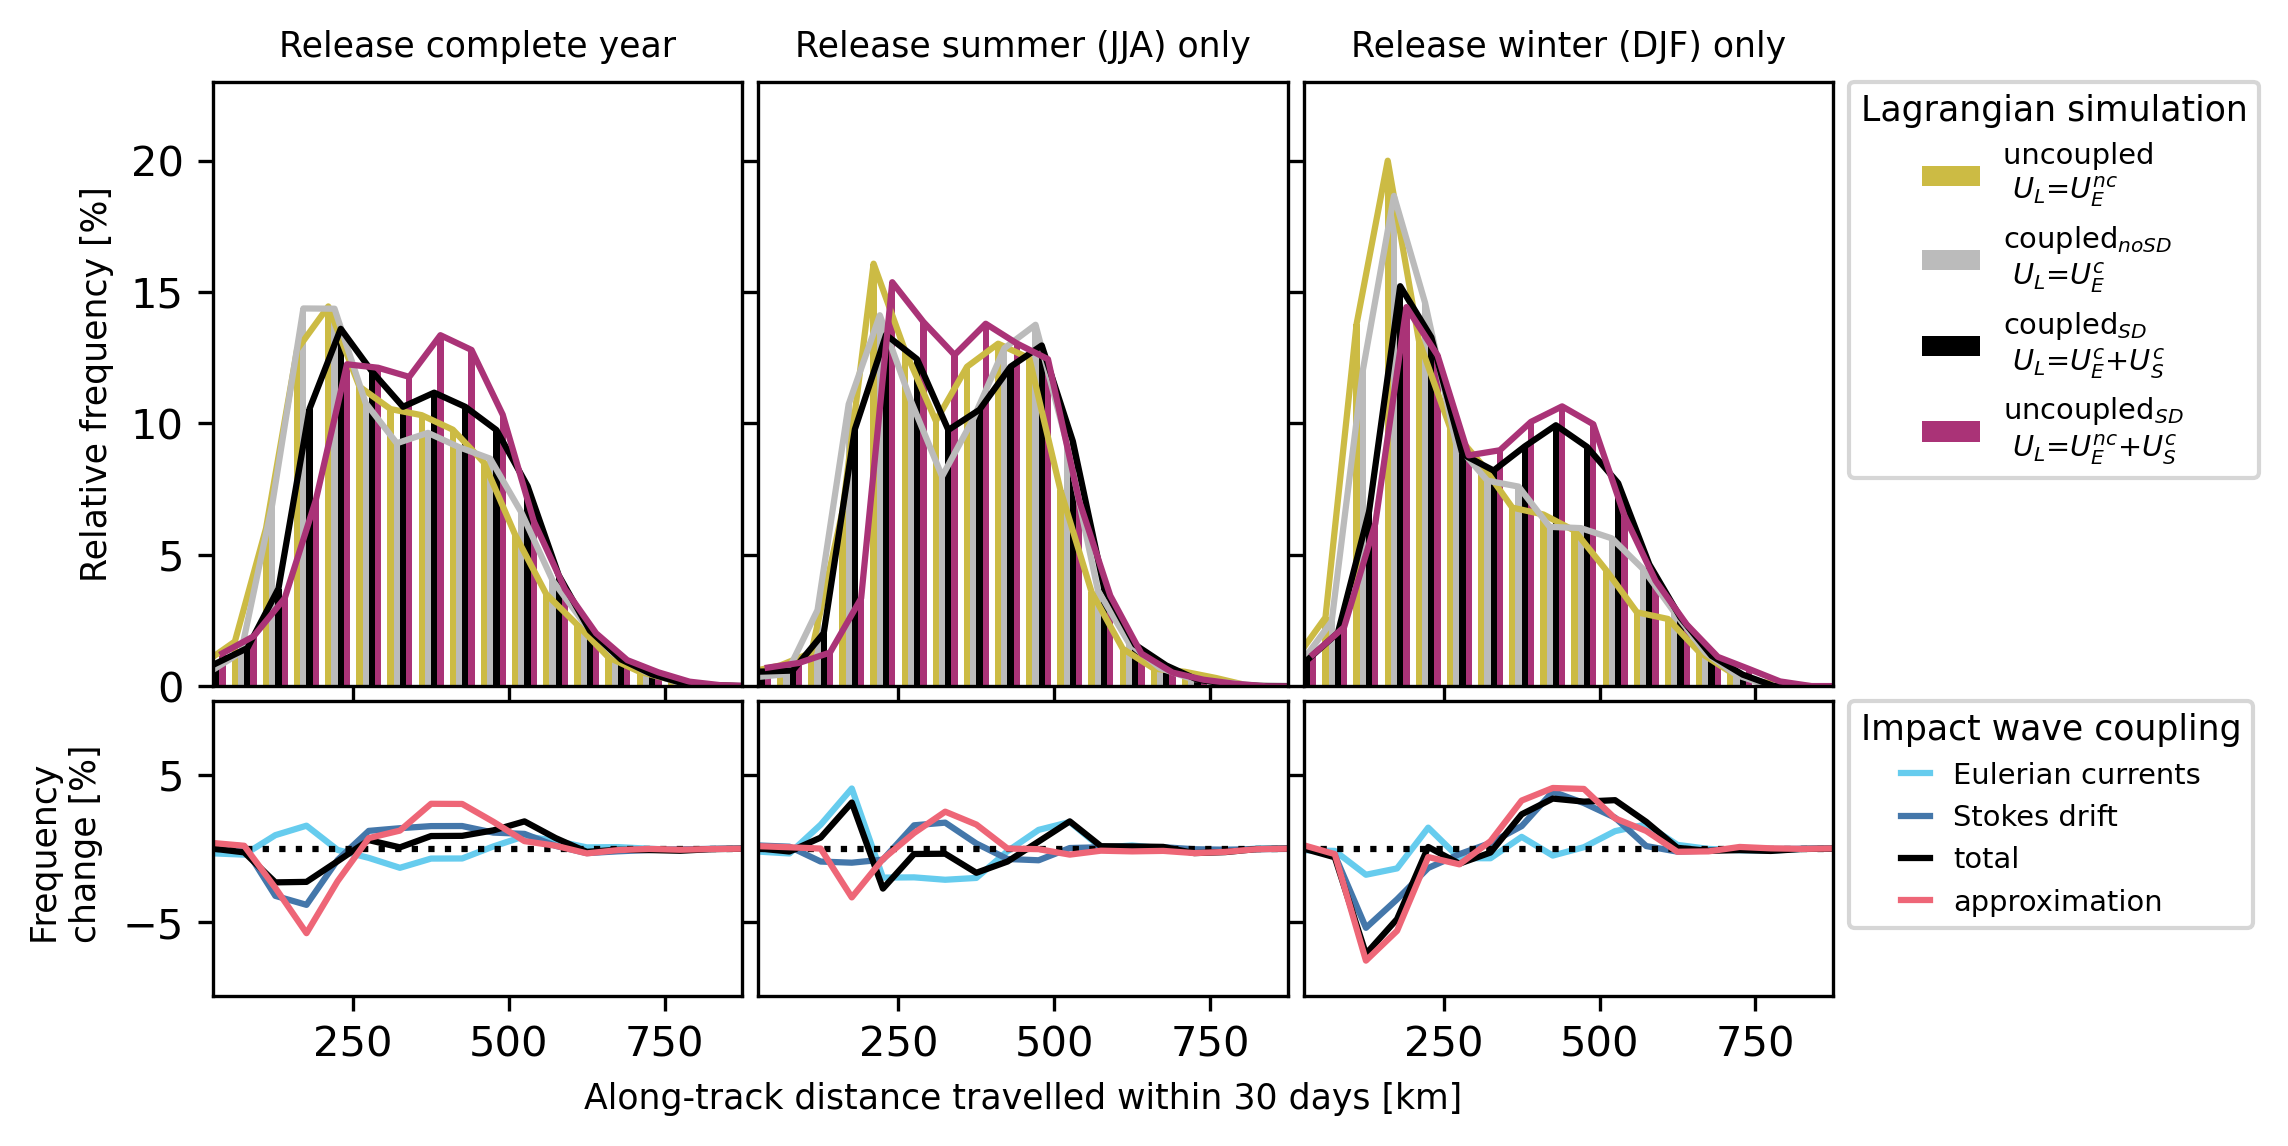

In [30]:
### Cumulative displacement/ along-track distance

bins = np.arange(0,950,50)
col_nc = col_yellow
col_ncsd = col_purple
col_csd = 'black'
col_cnosd = col_grey
col_euler = col_cyan
col_stokes = col_blue
col_approx = col_red
col_total = 'black'
bar_width = 10
lw1 = 1.5
fs = 'small'
fs2 = 'x-small'
tobs = 30


fig = plt.figure(figsize=(6,5.3), dpi=300, constrained_layout=False)
gs = fig.add_gridspec(nrows=4, ncols=3, 
                      left=0.05, right=0.95,
                      wspace=0.03, hspace=0.05)


# Distribution release whole year

var1 = dist_csd.rename('dist').isel(obs=tobs).stack(trajstack=('trajectory','start'))/1000
var2 = dist_cnosd.rename('dist').isel(obs=tobs).stack(trajstack=('trajectory','start'))/1000
var3 = dist_nc.rename('dist').isel(obs=tobs).stack(trajstack=('trajectory','start'))/1000
var4 = dist_ncsd.rename('dist').isel(obs=tobs).stack(trajstack=('trajectory','start'))/1000    
hist1 = histogram(var1, bins=[bins])
hist2 = histogram(var2, bins=[bins])
hist3 = histogram(var3, bins=[bins])
hist4 = histogram(var4, bins=[bins])
hist1b = hist1/hist1.sum()*100
hist2b = hist2/hist2.sum()*100
hist3b = hist3/hist3.sum()*100
hist4b = hist4/hist4.sum()*100

ax = fig.add_subplot(gs[:-2,0])
def plot_histcounts():
    plt.bar(hist3b.dist_bin-15, hist3b.values, 
            width=bar_width, color=col_nc,
            label='uncoupled \n $U_L$=$U_E^{nc}$')
    plt.bar(hist2b.dist_bin-5, hist2b.values, 
            width=bar_width, color=col_cnosd,
            label='coupled$_{noSD}$ \n $U_L$=$U_E^{c}$')
    plt.bar(hist1b.dist_bin+5, hist1b.values, 
            width=bar_width, color=col_csd,
            label='coupled$_{SD}$\n $U_L$=$U_E^{c}$+$U_S^{c}$')
    plt.bar(hist4b.dist_bin+15, hist4b.values, 
            width=bar_width, color=col_ncsd,
            label='uncoupled$_{SD}$ \n $U_L$=$U_E^{nc}$+$U_S^{c}$')
    ax.plot(hist3b.dist_bin-15,hist3b, color=col_nc, linewidth=lw1)
    ax.plot(hist2b.dist_bin-5,hist2b, color=col_cnosd, linewidth=lw1)
    ax.plot(hist1b.dist_bin+5,hist1b, color=col_csd, linewidth=lw1)
    ax.plot(hist4b.dist_bin+15,hist4b, color=col_ncsd, linewidth=lw1)
    ax.set_xlim([25,875])
    ax.set_ylim([0,23])
plot_histcounts()
ax.set_ylabel('Relative frequency [%]', fontsize=fs)
ax.set_title('Release complete year', fontsize=fs)

ax = fig.add_subplot(gs[2,0])
def plot_histdiff():
    ax.plot(hist1b.dist_bin,hist2b-hist3b,
            color=col_euler, linewidth=lw1, label='Eulerian currents')
    ax.plot(hist1b.dist_bin,hist1b-hist2b,
            color=col_stokes, linewidth=lw1, label='Stokes drift')
    ax.plot(hist1b.dist_bin,hist1b-hist3b,
            color=col_total, linewidth=lw1, label='total')
    ax.plot(hist1b.dist_bin,hist1b.dist_bin*0,
            color='k', linestyle='dotted', linewidth=lw1)
    ax.plot(hist1b.dist_bin,hist4b-hist3b,
            color=col_approx, linewidth=lw1, label='approximation')
    ax.set_xlim([25,875])
    ax.set_ylim([-10,10])
    ax.set_yticks([-5,5])
plot_histdiff()
ax.text(-210,0,'Frequency \n change [%]',
        fontsize=fs, rotation=90, ha='center', va='center' )



# Distribution summer

var1 = dist_csd.rename('dist').isel(obs=tobs,start=slice(31,49)).stack(trajstack=('trajectory','start'))/1000
var2 = dist_cnosd.rename('dist').isel(obs=tobs,start=slice(31,49)).stack(trajstack=('trajectory','start'))/1000
var3 = dist_nc.rename('dist').isel(obs=tobs,start=slice(31,49)).stack(trajstack=('trajectory','start'))/1000
var4 = dist_ncsd.rename('dist').isel(obs=tobs,start=slice(31,49)).stack(trajstack=('trajectory','start'))/1000
hist1 = histogram(var1, bins=[bins])
hist2 = histogram(var2, bins=[bins])
hist3 = histogram(var3, bins=[bins])
hist4 = histogram(var4, bins=[bins])
hist1b = hist1/hist1.sum()*100
hist2b = hist2/hist2.sum()*100
hist3b = hist3/hist3.sum()*100
hist4b = hist4/hist4.sum()*100

ax = fig.add_subplot(gs[:-2,1])
plot_histcounts()
ax.set_yticklabels([])
ax.set_title('Release summer (JJA) only', fontsize=fs)

ax = fig.add_subplot(gs[2,1])
plot_histdiff()
ax.set_yticklabels([])
ax.set_xlabel('Along-track distance travelled within 30 days [km]',fontsize=fs)


# Distribution winter

l1 = np.arange(0,12)
l2 = np.arange(67,73)
l3 = [*l1, *l2]
var1 = dist_csd.rename('dist').isel(obs=tobs,start=l3).stack(trajstack=('trajectory','start'))/1000
var2 = dist_cnosd.rename('dist').isel(obs=tobs,start=l3).stack(trajstack=('trajectory','start'))/1000
var3 = dist_nc.rename('dist').isel(obs=tobs,start=l3).stack(trajstack=('trajectory','start'))/1000
var4 = dist_ncsd.rename('dist').isel(obs=tobs,start=l3).stack(trajstack=('trajectory','start'))/1000
hist1 = histogram(var1, bins=[bins])
hist2 = histogram(var2, bins=[bins])
hist3 = histogram(var3, bins=[bins])
hist4 = histogram(var4, bins=[bins])
hist1b = hist1/hist1.sum()*100
hist2b = hist2/hist2.sum()*100
hist3b = hist3/hist3.sum()*100
hist4b = hist4/hist4.sum()*100

ax = fig.add_subplot(gs[:-2,2])
plot_histcounts()
ax.set_yticklabels([])
ax.set_title('Release winter (DJF) only', fontsize=fs)
ax.legend(bbox_to_anchor=(1.03, 1),loc='upper left',
          title="Lagrangian simulation", title_fontsize=fs,
          borderaxespad=0., fontsize=fs2)

ax = fig.add_subplot(gs[2,2])
plot_histdiff()
ax.set_yticklabels([])
ax.legend(bbox_to_anchor=(1.03, 1),loc='upper left', 
          title='Impact wave coupling', title_fontsize=fs,
          borderaxespad=0., fontsize=fs2,
          handlelength=1)

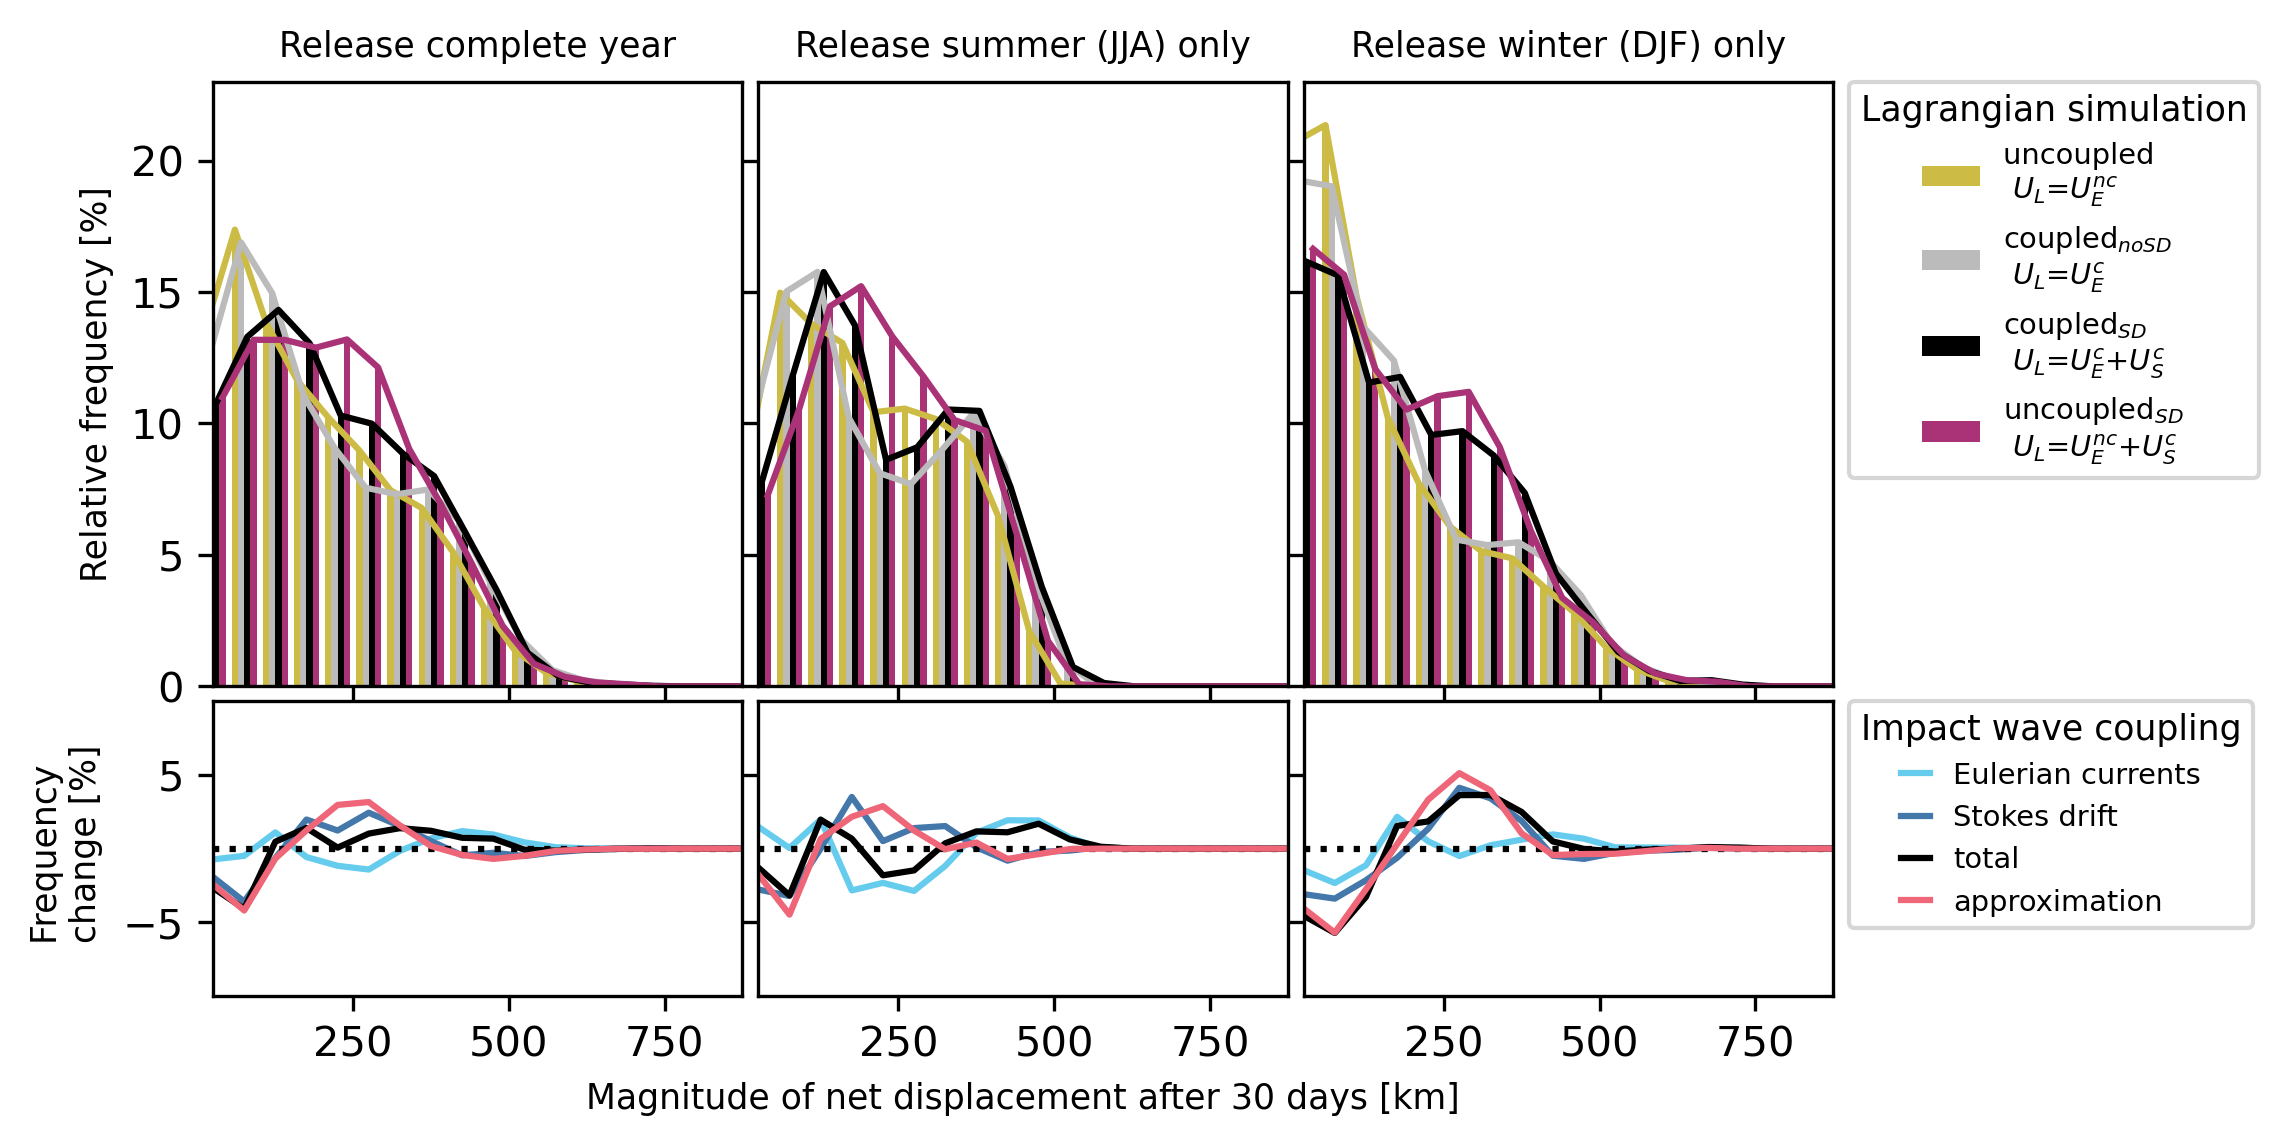

In [29]:
### Net displacement

bins = np.arange(0,950,50)
col_nc = col_yellow
col_ncsd = col_purple
col_csd = 'black'
col_cnosd = col_grey
col_euler = col_cyan
col_stokes = col_blue
col_approx = col_red
col_total = 'black'
bar_width = 10
lw1 = 1.5
fs = 'small'
fs2 = 'x-small'
tobs = 30


fig = plt.figure(figsize=(6,5.3), dpi=300, constrained_layout=False)
gs = fig.add_gridspec(nrows=4, ncols=3, 
                      left=0.05, right=0.95,
                      wspace=0.03, hspace=0.05)


# Distribution release whole year
var1 = traj_disp30d_csd.rename('dist').stack(trajstack=('trajectory','start'))
var2 = traj_disp30d_cnosd.rename('dist').stack(trajstack=('trajectory','start'))
var3 = traj_disp30d_nc.rename('dist').stack(trajstack=('trajectory','start'))
var4 = traj_disp30d_ncsd.rename('dist').stack(trajstack=('trajectory','start'))     
hist1 = histogram(var1, bins=[bins])
hist2 = histogram(var2, bins=[bins])
hist3 = histogram(var3, bins=[bins])
hist4 = histogram(var4, bins=[bins])
hist1b = hist1/hist1.sum()*100
hist2b = hist2/hist2.sum()*100
hist3b = hist3/hist3.sum()*100
hist4b = hist4/hist4.sum()*100

ax = fig.add_subplot(gs[:-2,0])
def plot_histcounts():
    plt.bar(hist3b.dist_bin-15, hist3b.values, 
            width=bar_width, color=col_nc,
            label='uncoupled \n $U_L$=$U_E^{nc}$')
    plt.bar(hist2b.dist_bin-5, hist2b.values, 
            width=bar_width, color=col_cnosd,
            label='coupled$_{noSD}$ \n $U_L$=$U_E^{c}$')
    plt.bar(hist1b.dist_bin+5, hist1b.values, 
            width=bar_width, color=col_csd,
            label='coupled$_{SD}$\n $U_L$=$U_E^{c}$+$U_S^{c}$')
    plt.bar(hist4b.dist_bin+15, hist4b.values, 
            width=bar_width, color=col_ncsd,
            label='uncoupled$_{SD}$ \n $U_L$=$U_E^{nc}$+$U_S^{c}$')
    ax.plot(hist3b.dist_bin-15,hist3b, color=col_nc, linewidth=lw1)
    ax.plot(hist2b.dist_bin-5,hist2b, color=col_cnosd, linewidth=lw1)
    ax.plot(hist1b.dist_bin+5,hist1b, color=col_csd, linewidth=lw1)
    ax.plot(hist4b.dist_bin+15,hist4b, color=col_ncsd, linewidth=lw1)
    ax.set_xlim([25,875])
    ax.set_ylim([0,23])
plot_histcounts()
ax.set_ylabel('Relative frequency [%]', fontsize=fs)
ax.set_title('Release complete year', fontsize=fs)

ax = fig.add_subplot(gs[2,0])
def plot_histdiff():
    ax.plot(hist1b.dist_bin,hist2b-hist3b,
            color=col_euler, linewidth=lw1, label='Eulerian currents')
    ax.plot(hist1b.dist_bin,hist1b-hist2b,
            color=col_stokes, linewidth=lw1, label='Stokes drift')
    ax.plot(hist1b.dist_bin,hist1b-hist3b,
            color=col_total, linewidth=lw1, label='total')
    ax.plot(hist1b.dist_bin,hist1b.dist_bin*0,
            color='k', linestyle='dotted', linewidth=lw1)
    ax.plot(hist1b.dist_bin,hist4b-hist3b,
            color=col_approx, linewidth=lw1, label='approximation')
    ax.set_xlim([25,875])
    ax.set_ylim([-10,10])
    ax.set_yticks([-5,5])
plot_histdiff()
ax.text(-210,0,'Frequency \n change [%]',
        fontsize=fs, rotation=90, ha='center', va='center' )



# Distribution summer

var1 = traj_disp30d_csd.rename('dist').isel(start=slice(31,49)).stack(trajstack=('trajectory','start'))
var2 = traj_disp30d_cnosd.rename('dist').isel(start=slice(31,49)).stack(trajstack=('trajectory','start'))
var3 = traj_disp30d_nc.rename('dist').isel(start=slice(31,49)).stack(trajstack=('trajectory','start'))
var4 = traj_disp30d_ncsd.rename('dist').isel(start=slice(31,49)).stack(trajstack=('trajectory','start'))
hist1 = histogram(var1, bins=[bins])
hist2 = histogram(var2, bins=[bins])
hist3 = histogram(var3, bins=[bins])
hist4 = histogram(var4, bins=[bins])
hist1b = hist1/hist1.sum()*100
hist2b = hist2/hist2.sum()*100
hist3b = hist3/hist3.sum()*100
hist4b = hist4/hist4.sum()*100

ax = fig.add_subplot(gs[:-2,1])
plot_histcounts()
ax.set_yticklabels([])
ax.set_title('Release summer (JJA) only', fontsize=fs)

ax = fig.add_subplot(gs[2,1])
plot_histdiff()
ax.set_yticklabels([])
ax.set_xlabel('Magnitude of net displacement after 30 days [km]',fontsize=fs)


# Distribution winter

l1 = np.arange(0,12)
l2 = np.arange(67,73)
l3 = [*l1, *l2]
var1 = traj_disp30d_csd.rename('dist').isel(start=l3).stack(trajstack=('trajectory','start'))
var2 = traj_disp30d_cnosd.rename('dist').isel(start=l3).stack(trajstack=('trajectory','start'))
var3 = traj_disp30d_nc.rename('dist').isel(start=l3).stack(trajstack=('trajectory','start'))
var4 = traj_disp30d_ncsd.rename('dist').isel(start=l3).stack(trajstack=('trajectory','start'))
hist1 = histogram(var1, bins=[bins])
hist2 = histogram(var2, bins=[bins])
hist3 = histogram(var3, bins=[bins])
hist4 = histogram(var4, bins=[bins])
hist1b = hist1/hist1.sum()*100
hist2b = hist2/hist2.sum()*100
hist3b = hist3/hist3.sum()*100
hist4b = hist4/hist4.sum()*100

ax = fig.add_subplot(gs[:-2,2])
plot_histcounts()
ax.set_yticklabels([])
ax.set_title('Release winter (DJF) only', fontsize=fs)
ax.legend(bbox_to_anchor=(1.03, 1),loc='upper left',
          title="Lagrangian simulation", title_fontsize=fs,
          borderaxespad=0., fontsize=fs2)

ax = fig.add_subplot(gs[2,2])
plot_histdiff()
ax.set_yticklabels([])
ax.legend(bbox_to_anchor=(1.03, 1),loc='upper left', 
          title='Impact wave coupling', title_fontsize=fs,
          borderaxespad=0., fontsize=fs2,
          handlelength=1)

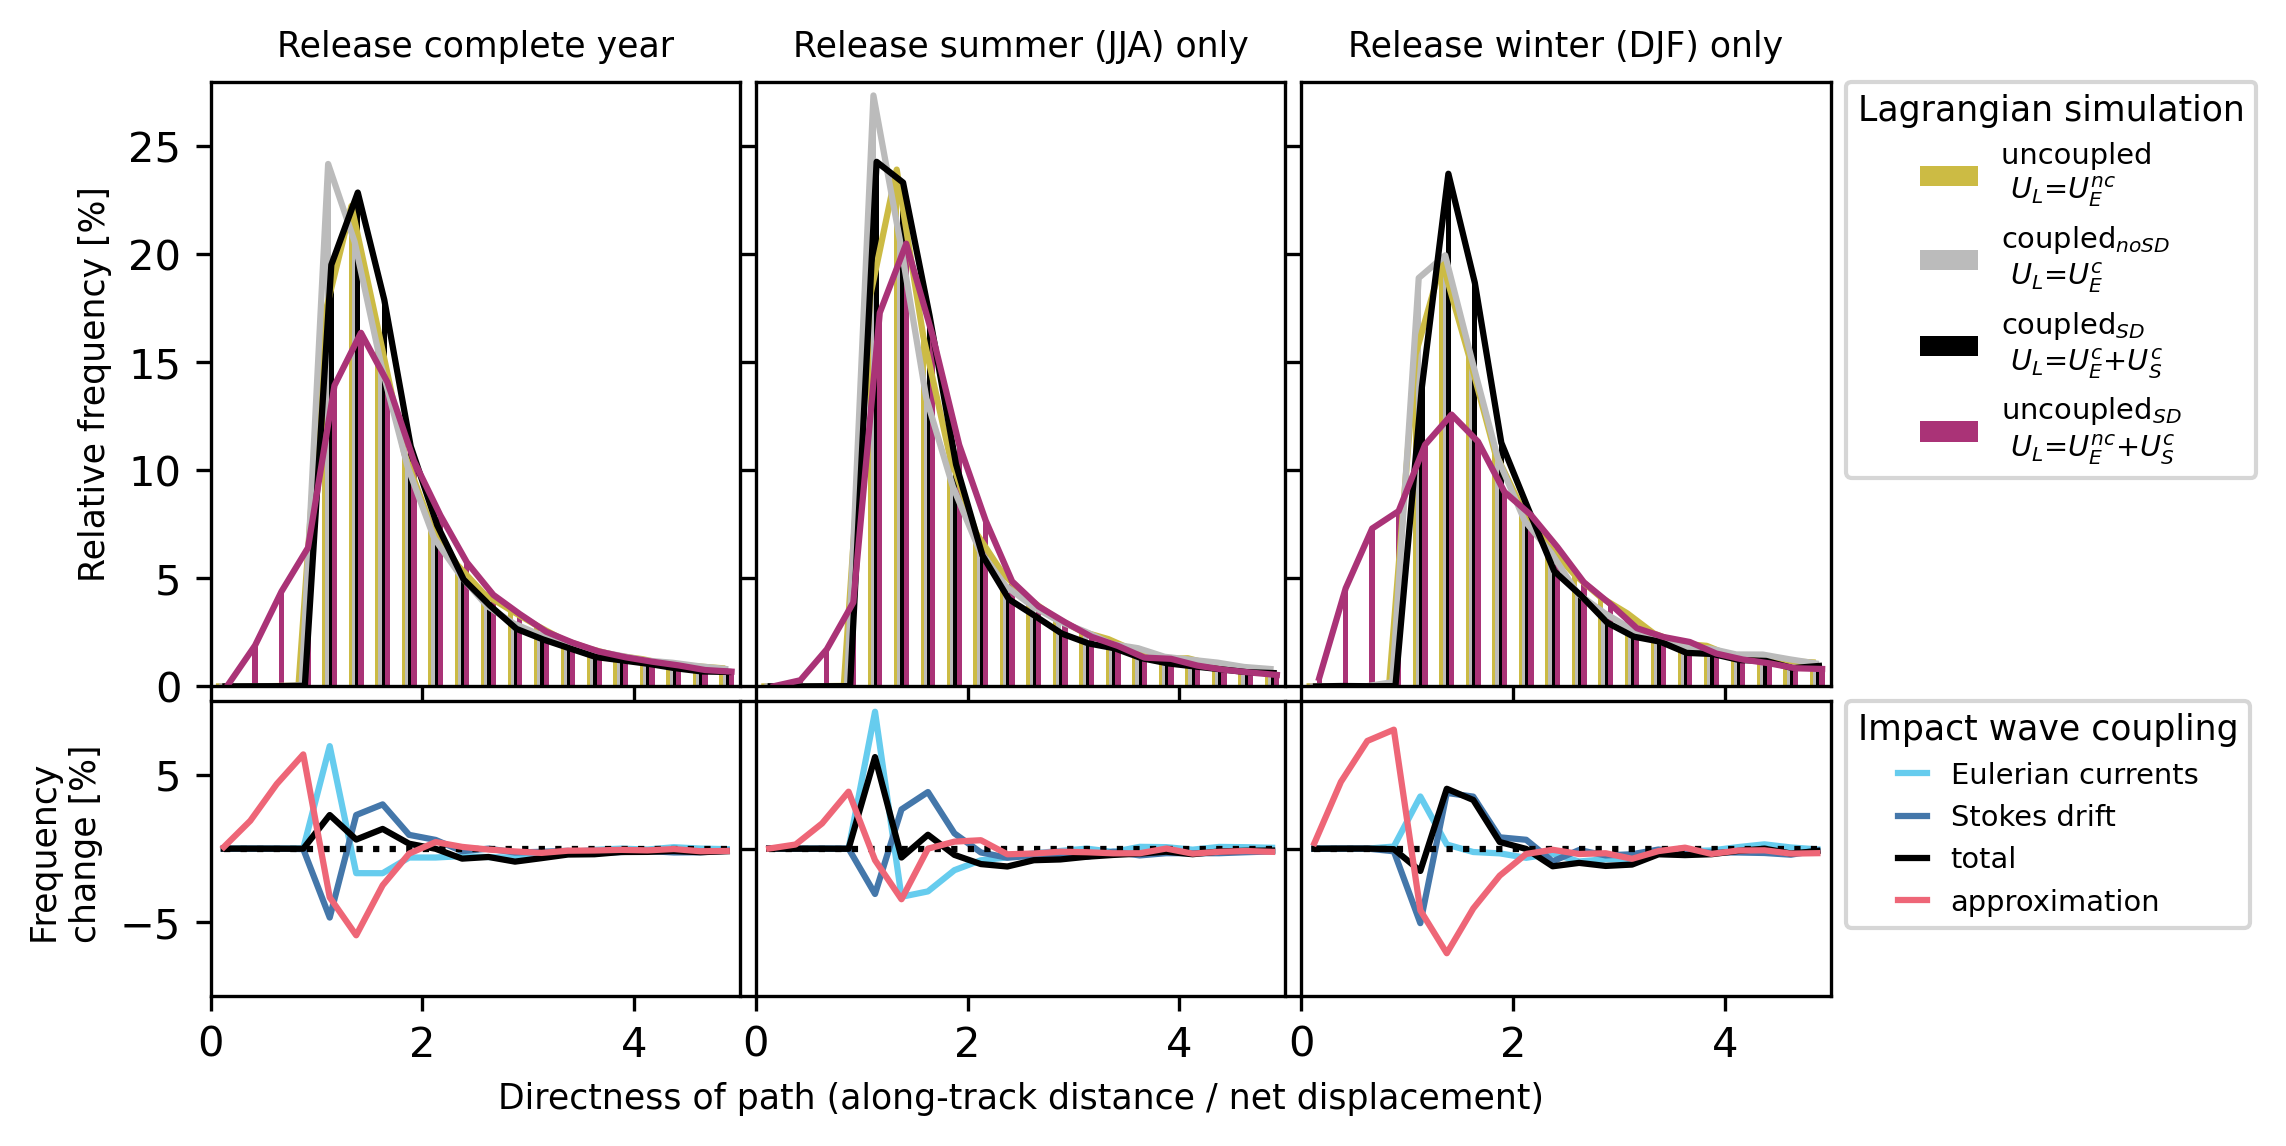

In [28]:
### Directness of path: Ratio along-track distance/net displacement

bins = np.arange(0,5.25,0.25)
col_nc = col_yellow
col_ncsd = col_purple
col_csd = 'black'
col_cnosd = col_grey
col_euler = col_cyan
col_stokes = col_blue
col_approx = col_red
col_total = 'black'
bar_width = 0.05
lw1 = 1.5
fs = 'small'
fs2 = 'x-small'
tobs = 30
xmin = 0
xmax = 5
ymin1 = 0
ymax1 = 28
ymin2 = -10
ymax2 = 10


fig = plt.figure(figsize=(6,5.3), dpi=300, constrained_layout=False)
gs = fig.add_gridspec(nrows=4, ncols=3, 
                      left=0.05, right=0.95,
                      wspace=0.03, hspace=0.05)


# Distribution release whole year
var1 = (dist_csd.rename('dist').isel(obs=tobs)/1000 /
        traj_disp30d_csd.rename('dist')).stack(trajstack=('trajectory','start'))
var2 = (dist_cnosd.rename('dist').isel(obs=tobs)/1000 /
        traj_disp30d_cnosd.rename('dist')).stack(trajstack=('trajectory','start'))
var3 = (dist_nc.rename('dist').isel(obs=tobs)/1000 / 
        traj_disp30d_nc.rename('dist')).stack(trajstack=('trajectory','start'))
var4 = (dist_nc.rename('dist').isel(obs=tobs)/1000 / 
        traj_disp30d_ncsd.rename('dist')).stack(trajstack=('trajectory','start'))     
hist1 = histogram(var1, bins=[bins])
hist2 = histogram(var2, bins=[bins])
hist3 = histogram(var3, bins=[bins])
hist4 = histogram(var4, bins=[bins])
hist1b = hist1/hist1.sum()*100
hist2b = hist2/hist2.sum()*100
hist3b = hist3/hist3.sum()*100
hist4b = hist4/hist4.sum()*100

ax = fig.add_subplot(gs[:-2,0])
def plot_histcounts():
    plt.bar(hist3b.dist_bin-bar_width*0.9, hist3b.values, 
            width=bar_width, color=col_nc,
            label='uncoupled \n $U_L$=$U_E^{nc}$')
    plt.bar(hist2b.dist_bin-bar_width*0.3, hist2b.values, 
            width=bar_width, color=col_cnosd,
            label='coupled$_{noSD}$ \n $U_L$=$U_E^{c}$')
    plt.bar(hist1b.dist_bin+bar_width*0.3, hist1b.values, 
            width=bar_width, color=col_csd,
            label='coupled$_{SD}$\n $U_L$=$U_E^{c}$+$U_S^{c}$')
    plt.bar(hist4b.dist_bin+bar_width*0.9, hist4b.values, 
            width=bar_width, color=col_ncsd,
            label='uncoupled$_{SD}$ \n $U_L$=$U_E^{nc}$+$U_S^{c}$')
    ax.plot(hist3b.dist_bin-bar_width*0.9,hist3b, color=col_nc, linewidth=lw1)
    ax.plot(hist2b.dist_bin-bar_width*0.3,hist2b, color=col_cnosd, linewidth=lw1)
    ax.plot(hist1b.dist_bin+bar_width*0.3,hist1b, color=col_csd, linewidth=lw1)
    ax.plot(hist4b.dist_bin+bar_width*0.9,hist4b, color=col_ncsd, linewidth=lw1)
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin1,ymax1])
    ax.set_xticklabels([])
plot_histcounts()
ax.set_ylabel('Relative frequency [%]', fontsize=fs)
ax.set_title('Release complete year', fontsize=fs)

ax = fig.add_subplot(gs[2,0])
def plot_histdiff():
    ax.plot(hist1b.dist_bin,hist2b-hist3b,
            color=col_euler, linewidth=lw1, label='Eulerian currents')
    ax.plot(hist1b.dist_bin,hist1b-hist2b,
            color=col_stokes, linewidth=lw1, label='Stokes drift')
    ax.plot(hist1b.dist_bin,hist1b-hist3b,
            color=col_total, linewidth=lw1, label='total')
    ax.plot(hist1b.dist_bin,hist1b.dist_bin*0,
            color='k', linestyle='dotted', linewidth=lw1)
    ax.plot(hist1b.dist_bin,hist4b-hist3b,
            color=col_approx, linewidth=lw1, label='approximation')
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin2,ymax2])
plot_histdiff()
ax.set_yticks([ymin2/2,ymax2/2])
ax.set_ylabel('Frequency \n change [%]', fontsize=fs)

# Distribution summer
var1 = (dist_csd.rename('dist').isel(obs=tobs)/1000 /
        traj_disp30d_csd.rename('dist')).isel(start=slice(31,49)).stack(trajstack=('trajectory','start'))
var2 = (dist_cnosd.rename('dist').isel(obs=tobs)/1000 /
        traj_disp30d_cnosd.rename('dist')).isel(start=slice(31,49)).stack(trajstack=('trajectory','start'))
var3 = (dist_nc.rename('dist').isel(obs=tobs)/1000 / 
        traj_disp30d_nc.rename('dist')).isel(start=slice(31,49)).stack(trajstack=('trajectory','start'))
var4 = (dist_nc.rename('dist').isel(obs=tobs)/1000 / 
        traj_disp30d_ncsd.rename('dist')).isel(start=slice(31,49)).stack(trajstack=('trajectory','start'))   
hist1 = histogram(var1, bins=[bins])
hist2 = histogram(var2, bins=[bins])
hist3 = histogram(var3, bins=[bins])
hist4 = histogram(var4, bins=[bins])
hist1b = hist1/hist1.sum()*100
hist2b = hist2/hist2.sum()*100
hist3b = hist3/hist3.sum()*100
hist4b = hist4/hist4.sum()*100

ax = fig.add_subplot(gs[:-2,1])
plot_histcounts()
ax.set_yticklabels([])
ax.set_title('Release summer (JJA) only', fontsize=fs)

ax = fig.add_subplot(gs[2,1])
plot_histdiff()
ax.set_yticklabels([])
ax.set_xlabel('Directness of path (along-track distance / net displacement)',fontsize=fs)


# Distribution winter

l1 = np.arange(0,12)
l2 = np.arange(67,73)
l3 = [*l1, *l2]
var1 = (dist_csd.rename('dist').isel(obs=tobs)/1000 /
        traj_disp30d_csd.rename('dist')).isel(start=l3).stack(trajstack=('trajectory','start'))
var2 = (dist_cnosd.rename('dist').isel(obs=tobs)/1000 /
        traj_disp30d_cnosd.rename('dist')).isel(start=l3).stack(trajstack=('trajectory','start'))
var3 = (dist_nc.rename('dist').isel(obs=tobs)/1000 / 
        traj_disp30d_nc.rename('dist')).isel(start=l3).stack(trajstack=('trajectory','start'))
var4 = (dist_nc.rename('dist').isel(obs=tobs)/1000 / 
        traj_disp30d_ncsd.rename('dist')).isel(start=l3).stack(trajstack=('trajectory','start'))  
hist1 = histogram(var1, bins=[bins])
hist2 = histogram(var2, bins=[bins])
hist3 = histogram(var3, bins=[bins])
hist4 = histogram(var4, bins=[bins])
hist1b = hist1/hist1.sum()*100
hist2b = hist2/hist2.sum()*100
hist3b = hist3/hist3.sum()*100
hist4b = hist4/hist4.sum()*100

ax = fig.add_subplot(gs[:-2,2])
plot_histcounts()
ax.set_yticklabels([])
ax.set_title('Release winter (DJF) only', fontsize=fs)
ax.legend(bbox_to_anchor=(1.03, 1),loc='upper left',
          title="Lagrangian simulation", title_fontsize=fs,
          borderaxespad=0., fontsize=fs2)

ax = fig.add_subplot(gs[2,2])
plot_histdiff()
ax.set_yticklabels([])
ax.legend(bbox_to_anchor=(1.03, 1),loc='upper left', 
          title='Impact wave coupling', title_fontsize=fs,
          borderaxespad=0., fontsize=fs2,
          handlelength=1)

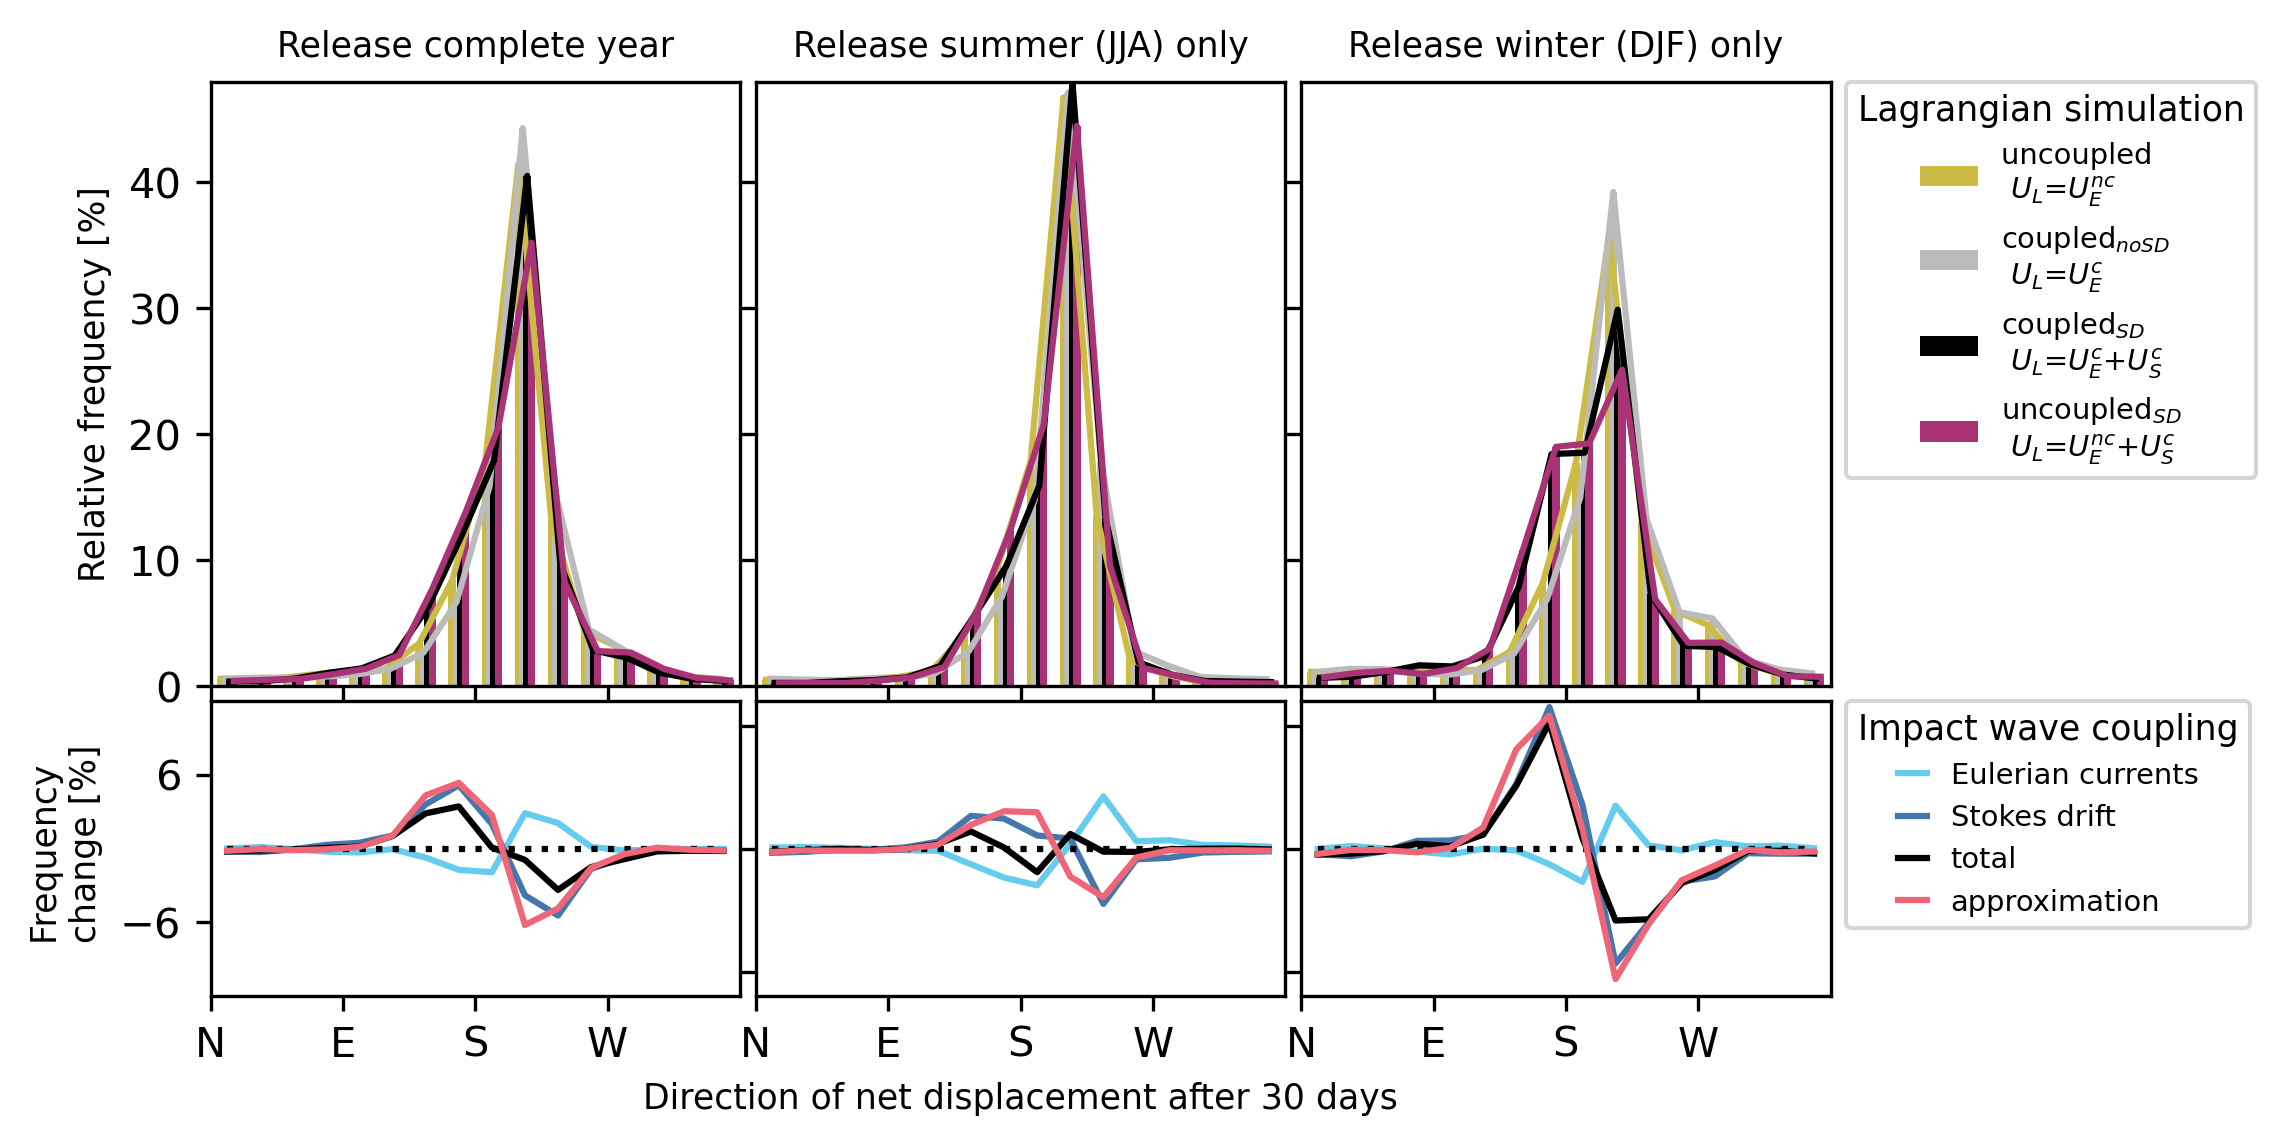

In [27]:
### Direction of net displacement


# Distribution release whole year

   
bins = np.arange(0,380.5,22.5)
col_nc = col_yellow
col_ncsd = col_purple
col_csd = 'black'
col_cnosd = col_grey
col_euler = col_cyan
col_stokes = col_blue
col_approx = col_red
col_total = 'black'
bar_width = 5
lw1 = 1.5
fs = 'small'
fs2 = 'x-small'
tobs = 30
xmin = 0
xmax = 360
xticks = [0,90,180,270]
xticklabs = ['N','E','S','W']
ymin1 = 0
ymax1 = 48
ymin2 = -12
ymax2 = 12


fig = plt.figure(figsize=(6,5.3), dpi=300, constrained_layout=False)
gs = fig.add_gridspec(nrows=4, ncols=3, 
                      left=0.05, right=0.95,
                      wspace=0.03, hspace=0.05)


# Distribution release whole year
var1 = traj_dispdir30d_csd.rename('dist').isel(obs=30).stack(trajstack=('trajectory','start'))
var2 = traj_dispdir30d_cnosd.rename('dist').isel(obs=30).stack(trajstack=('trajectory','start'))
var3 = traj_dispdir30d_nc.rename('dist').isel(obs=30).stack(trajstack=('trajectory','start'))
var4 = traj_dispdir30d_ncsd.rename('dist').isel(obs=30).stack(trajstack=('trajectory','start'))    
hist1 = histogram(var1, bins=[bins])
hist2 = histogram(var2, bins=[bins])
hist3 = histogram(var3, bins=[bins])
hist4 = histogram(var4, bins=[bins])
hist1b = hist1/hist1.sum()*100
hist2b = hist2/hist2.sum()*100
hist3b = hist3/hist3.sum()*100
hist4b = hist4/hist4.sum()*100

ax = fig.add_subplot(gs[:-2,0])
def plot_histcounts():
    plt.bar(hist3b.dist_bin-bar_width*0.9, hist3b.values, 
            width=bar_width, color=col_nc,
            label='uncoupled \n $U_L$=$U_E^{nc}$')
    plt.bar(hist2b.dist_bin-bar_width*0.3, hist2b.values, 
            width=bar_width, color=col_cnosd,
            label='coupled$_{noSD}$ \n $U_L$=$U_E^{c}$')
    plt.bar(hist1b.dist_bin+bar_width*0.3, hist1b.values, 
            width=bar_width, color=col_csd,
            label='coupled$_{SD}$\n $U_L$=$U_E^{c}$+$U_S^{c}$')
    plt.bar(hist4b.dist_bin+bar_width*0.9, hist4b.values, 
            width=bar_width, color=col_ncsd,
            label='uncoupled$_{SD}$ \n $U_L$=$U_E^{nc}$+$U_S^{c}$')
    ax.plot(hist3b.dist_bin-bar_width*0.9,hist3b, color=col_nc, linewidth=lw1)
    ax.plot(hist2b.dist_bin-bar_width*0.3,hist2b, color=col_cnosd, linewidth=lw1)
    ax.plot(hist1b.dist_bin+bar_width*0.3,hist1b, color=col_csd, linewidth=lw1)
    ax.plot(hist4b.dist_bin+bar_width*0.9,hist4b, color=col_ncsd, linewidth=lw1)
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin1,ymax1])
    ax.set_xticks(xticks)
    ax.set_xticklabels([])
plot_histcounts()
ax.set_ylabel('Relative frequency [%]', fontsize=fs)
ax.set_title('Release complete year', fontsize=fs)

ax = fig.add_subplot(gs[2,0])
def plot_histdiff():
    ax.plot(hist1b.dist_bin,hist2b-hist3b,
            color=col_euler, linewidth=lw1, label='Eulerian currents')
    ax.plot(hist1b.dist_bin,hist1b-hist2b,
            color=col_stokes, linewidth=lw1, label='Stokes drift')
    ax.plot(hist1b.dist_bin,hist1b-hist3b,
            color=col_total, linewidth=lw1, label='total')
    ax.plot(hist1b.dist_bin,hist1b.dist_bin*0,
            color='k', linestyle='dotted', linewidth=lw1)
    ax.plot(hist1b.dist_bin,hist4b-hist3b,
            color=col_approx, linewidth=lw1, label='approximation')
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin2,ymax2])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabs)
plot_histdiff()
ax.set_yticks([ymin2/2,ymax2/2])
ax.set_ylabel('Frequency \n change [%]', fontsize=fs)

# Distribution summer
var1 = traj_dispdir30d_csd.rename('dist').isel(start=slice(31,49),obs=30).stack(trajstack=('trajectory','start'))
var2 = traj_dispdir30d_cnosd.rename('dist').isel(start=slice(31,49),obs=30).stack(trajstack=('trajectory','start'))
var3 = traj_dispdir30d_nc.rename('dist').isel(start=slice(31,49),obs=30).stack(trajstack=('trajectory','start'))
var4 = traj_dispdir30d_ncsd.rename('dist').isel(start=slice(31,49),obs=30).stack(trajstack=('trajectory','start')) 
hist1 = histogram(var1, bins=[bins])
hist2 = histogram(var2, bins=[bins])
hist3 = histogram(var3, bins=[bins])
hist4 = histogram(var4, bins=[bins])
hist1b = hist1/hist1.sum()*100
hist2b = hist2/hist2.sum()*100
hist3b = hist3/hist3.sum()*100
hist4b = hist4/hist4.sum()*100

ax = fig.add_subplot(gs[:-2,1])
plot_histcounts()
ax.set_yticklabels([])
ax.set_title('Release summer (JJA) only', fontsize=fs)

ax = fig.add_subplot(gs[2,1])
plot_histdiff()
ax.set_yticklabels([])
ax.set_xlabel('Direction of net displacement after 30 days',fontsize=fs)


# Distribution winter

l1 = np.arange(0,12)
l2 = np.arange(67,73)
l3 = [*l1, *l2]
var1 = traj_dispdir30d_csd.rename('dist').isel(start=l3,obs=30).stack(trajstack=('trajectory','start'))
var2 = traj_dispdir30d_cnosd.rename('dist').isel(start=l3,obs=30).stack(trajstack=('trajectory','start'))
var3 = traj_dispdir30d_nc.rename('dist').isel(start=l3,obs=30).stack(trajstack=('trajectory','start'))
var4 = traj_dispdir30d_ncsd.rename('dist').isel(start=l3,obs=30).stack(trajstack=('trajectory','start'))  
hist1 = histogram(var1, bins=[bins])
hist2 = histogram(var2, bins=[bins])
hist3 = histogram(var3, bins=[bins])
hist4 = histogram(var4, bins=[bins])
hist1b = hist1/hist1.sum()*100
hist2b = hist2/hist2.sum()*100
hist3b = hist3/hist3.sum()*100
hist4b = hist4/hist4.sum()*100

ax = fig.add_subplot(gs[:-2,2])
plot_histcounts()
ax.set_yticklabels([])
ax.set_title('Release winter (DJF) only', fontsize=fs)
ax.legend(bbox_to_anchor=(1.03, 1),loc='upper left',
          title="Lagrangian simulation", title_fontsize=fs,
          borderaxespad=0., fontsize=fs2)

ax = fig.add_subplot(gs[2,2])
plot_histdiff()
ax.set_yticklabels([])
ax.legend(bbox_to_anchor=(1.03, 1),loc='upper left', 
          title='Impact wave coupling', title_fontsize=fs,
          borderaxespad=0., fontsize=fs2,
          handlelength=1)

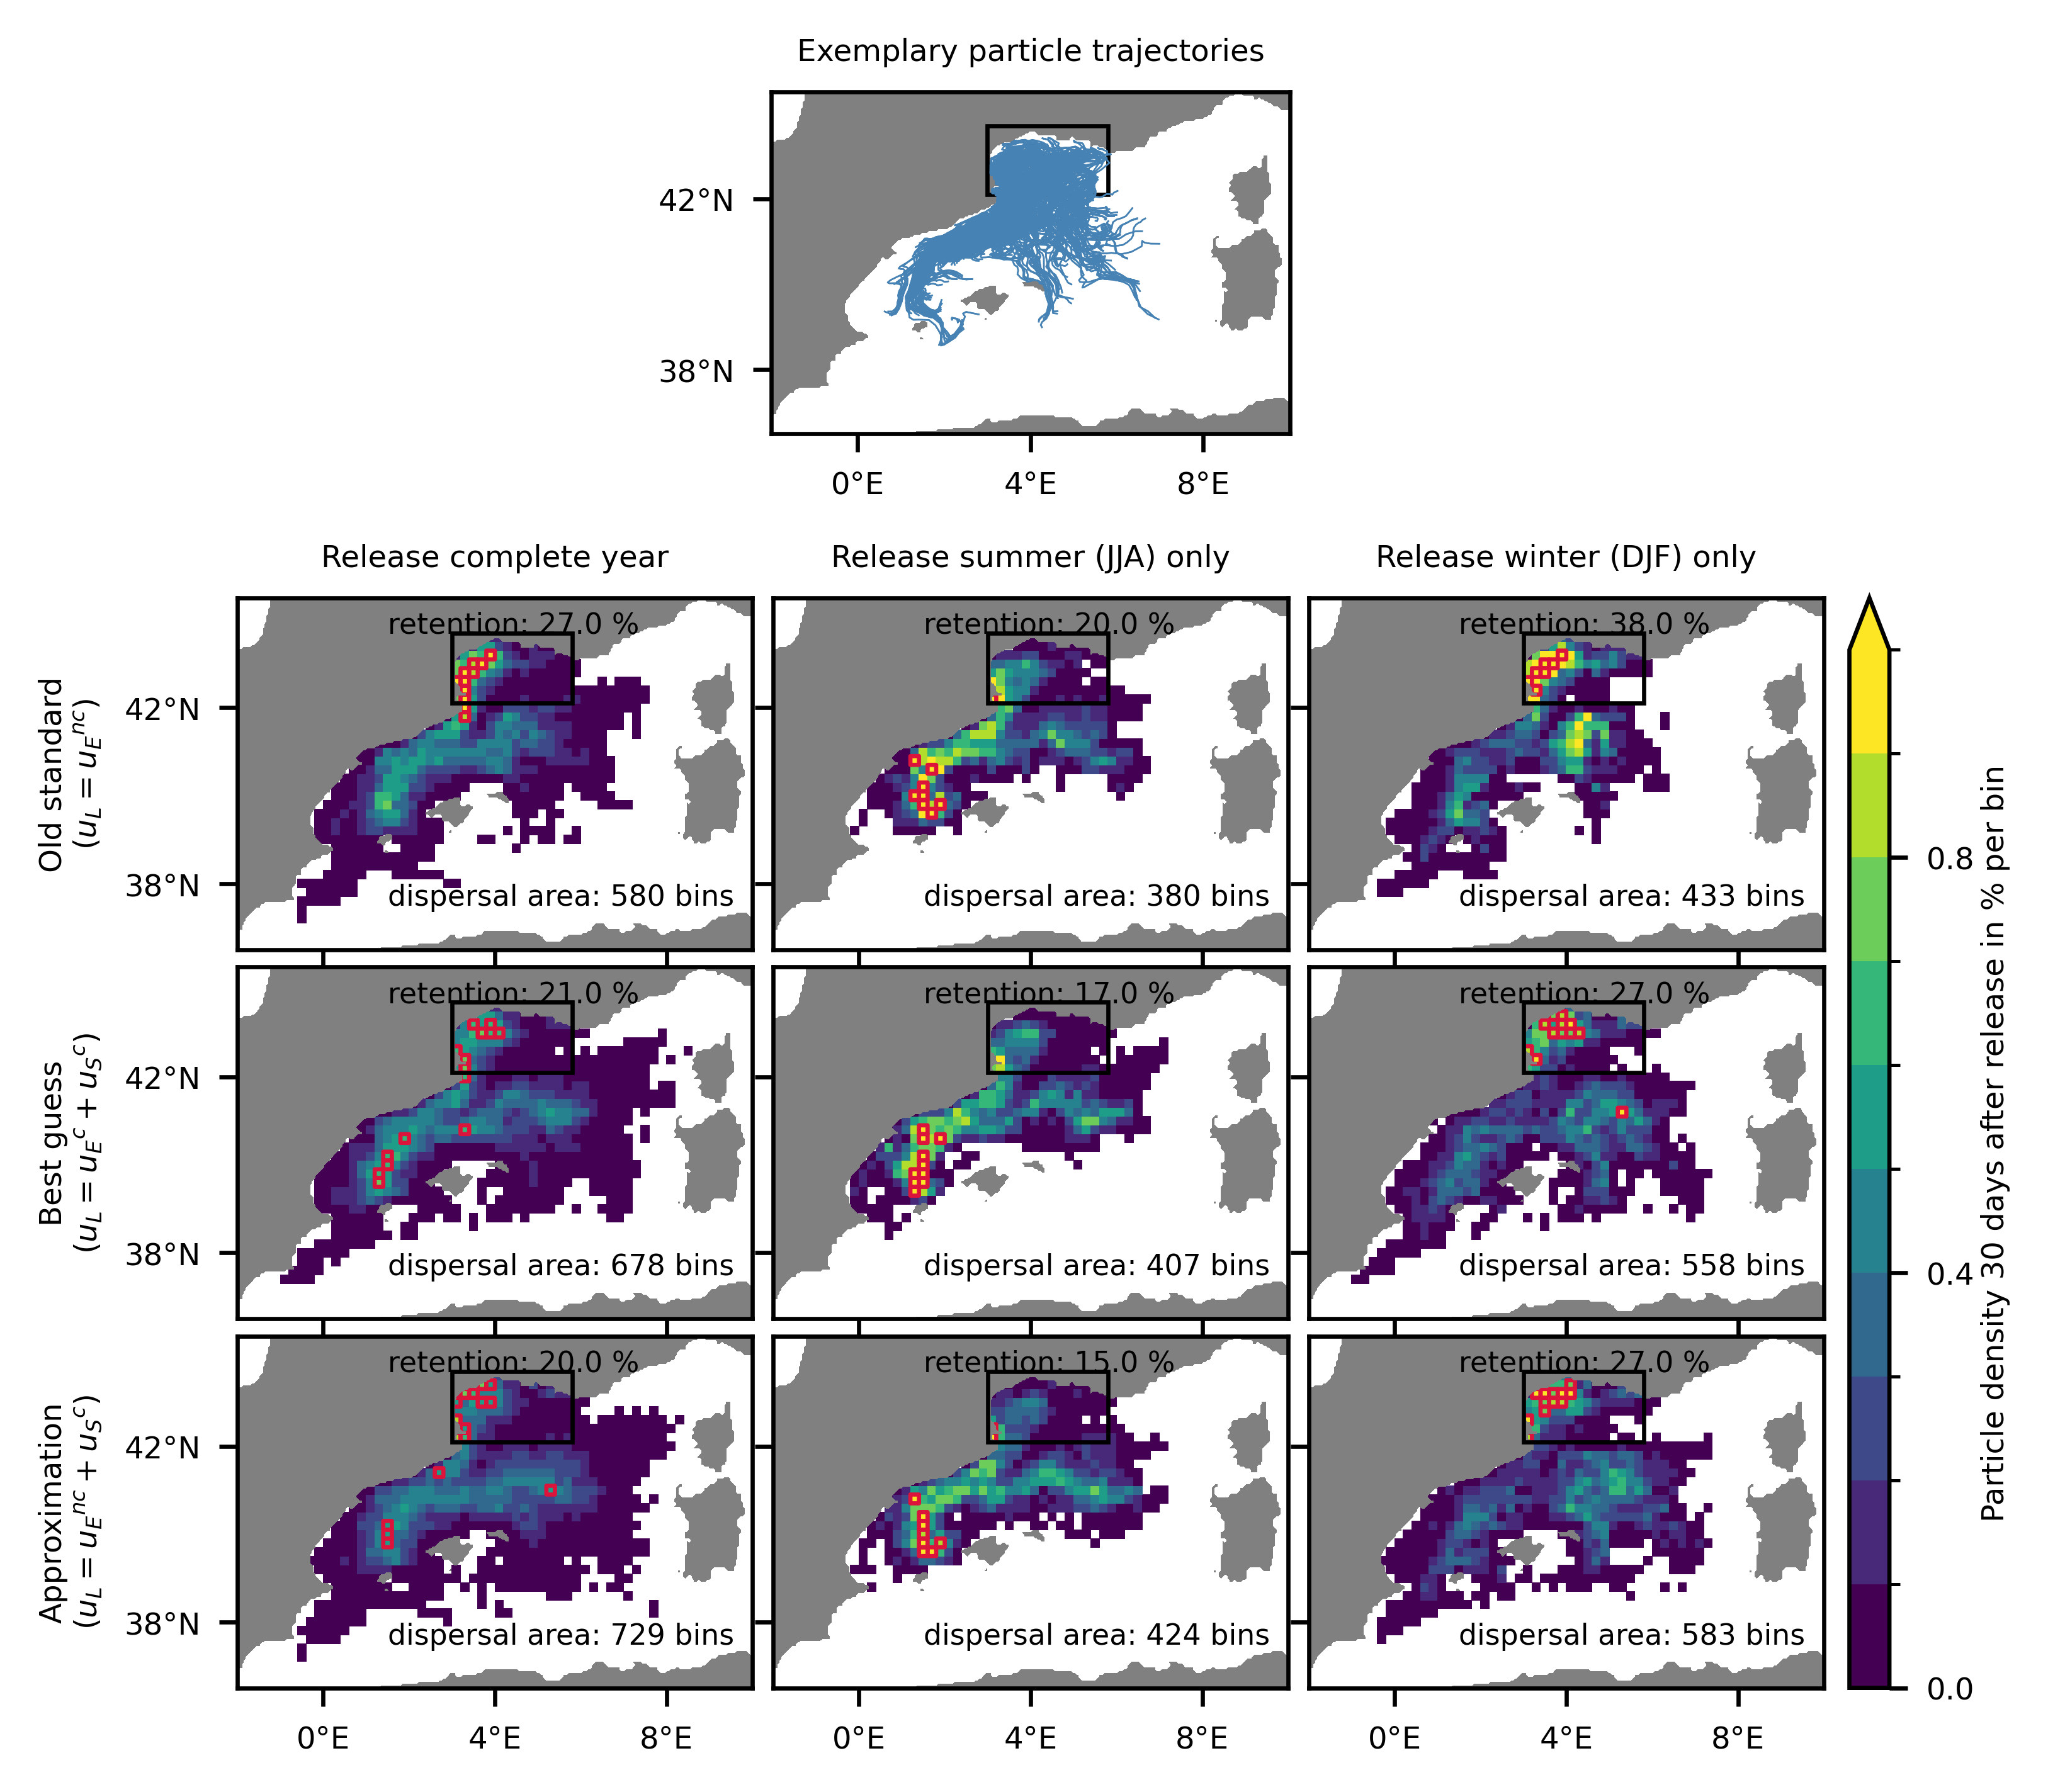

In [34]:
bins_lon = np.arange(-6,36,0.2); bins_lat =  np.arange(30.1,47,0.2)
lonmin = 3
lonmax = 5.6
latmin = 42.1
latmax = 43.5
step = 0.2
lonmin_plot = -2
lonmax_plot = 10
latmin_plot = 36.5
latmax_plot = 44.5
highproblev = 90
obstime = 30
traj_col = 'steelblue'

colm = cm.viridis 
levs = np.arange(0, 1.1, 0.1)
norm = colors.BoundaryNorm(boundaries=levs, ncolors=colm.N)
fs='xx-small'
nctic=3

def plot_2Dhist(var1):
    pos_y = var1.isel(obs=obstime).lat.stack(trajstack=('trajectory','start'))
    pos_x = var1.isel(obs=obstime).lon.stack(trajstack=('trajectory','start'))
    hist2D = histogram(pos_x, pos_y, bins=[bins_lon, bins_lat])
    hist2D_plot = hist2D.transpose()/hist2D.sum().values*100
    map = ax.pcolor(hist2D_plot.lon_bin, hist2D_plot.lat_bin,
                    hist2D_plot.where(hist2D_plot != 0),
                    cmap=colm, norm = norm,
                    shading='nearest')
    release_box = (((hist2D_plot.lon_bin >= lonmin) & (hist2D_plot.lon_bin <= lonmax)) &
                   ((hist2D_plot.lat_bin >= latmin) & (hist2D_plot.lat_bin <= latmax)))
    tmp = hist2D_plot.where(release_box)
    retention = tmp.sum()
    ax.annotate('retention: ' + str(retention.round().values) + ' %', (1.5, latmax+step), fontsize=5.5)
    area_bins = (hist2D_plot.where(hist2D_plot != 0)/hist2D_plot.where(hist2D_plot != 0)).sum()
    ax.text(1.5, 37.5, 'dispersal area: ' + str(int(area_bins.round().values)) + ' bins', fontsize=5.5)
    tmp2 = np.sort(hist2D_plot.stack(binstack=('lon_bin','lat_bin')))
    tmp3 = np.cumsum(tmp2)
    highprob = xr.DataArray(tmp2).where(tmp3 >= highproblev).squeeze(drop=True).min()
    ax.pcolor(hist2D_plot.lon_bin, hist2D_plot.lat_bin,
              hist2D_plot.where(hist2D_plot >= highprob),
              alpha=1.0, edgecolor='crimson', facecolor='none',
              linewidth=0.8,
              shading='nearest')
    del tmp, tmp2, tmp3
    return map

def plot_bathy():
    var = grid.mbathy
    var.rename({'x':'lon', 'y':'lat'})
    ax.contourf(grid.glamf.isel(time_counter=0), grid.gphif.isel(time_counter=0),
                var.isel(time_counter=0),[0,1],
                colors='grey')

def plot_releasebox():
    rect = patches.Rectangle((lonmin, latmin), lonmax-lonmin+step, latmax-latmin+step, 
                             linewidth=0.8,edgecolor='k', facecolor='none')
    ax.add_patch(rect)

def build_subplot(var1,xticklabel=True,yticklabel=True):
    map = plot_2Dhist(var1)
    plot_bathy()
    plot_releasebox()
    ax.set_xlim([lonmin_plot,lonmax_plot])
    ax.set_ylim([latmin_plot,latmax_plot])
    ax.set_xticks([0,4,8])
    ax.set_yticks([38,42])
    ax.set_xticklabels(['0°E','4°E','8°E'])
    ax.set_yticklabels(['38°N','42°N'])
    if xticklabel==False:
        ax.set_xticklabels([])
    if yticklabel==False:
        ax.set_yticklabels([])
    ax.tick_params(axis='both', labelsize=fs)
    return map

    
fig = plt.figure(figsize=(6,5.6), dpi=600, constrained_layout=False)
gs2 = fig.add_gridspec(nrows=100, ncols=3, 
                      left=0.1, right=0.8,
                      wspace=0.03, hspace=0.05)
gs = fig.add_gridspec(nrows=4, ncols=3, 
                      left=0.1, right=0.8,
                      top=0.8,
                      wspace=0.04, hspace=0.05)
gscbar = fig.add_gridspec(nrows=4, ncols=100, 
                          left=0.1, right=1,
                          top=0.8,
                          wspace=0.04, hspace=0.05)


# Exemplary trajectories

ax = fig.add_subplot(gs2[2:23,1])
plot_bathy()
plot_releasebox()
ax.set_xlim([lonmin_plot,lonmax_plot])
ax.set_ylim([latmin_plot,latmax_plot])
ax.set_xticks([0,4,8])
ax.set_yticks([38,42])
ax.set_xticklabels(['0°E','4°E','8°E'])
ax.set_yticklabels(['38°N','42°N'])
ax.tick_params(axis='both', labelsize=fs)
for i in np.arange(0,1100,10):
        for j in np.arange(0,72,18):
            plt.plot(traj_csd.lon.isel(start=j, trajectory=i), traj_csd.lat.isel(start=j, trajectory=i), color=traj_col, linewidth=0.3)
            plt.plot(traj_csd.lon.isel(start=j, trajectory=i), traj_csd.lat.isel(start=j, trajectory=i), color=traj_col, linewidth=0.3)
ax.set_title('Exemplary particle trajectories', fontsize=fs)


# Total distributions

ax = fig.add_subplot(gs[1,0])
var1 = traj_nc
var2 = dist_nc
map = build_subplot(var1, xticklabel=False)
ax.set_title('Release complete year', fontsize=fs)
ax.set_ylabel('Old standard\n($u_L = {u_E}^{nc}$)', fontsize=fs)

ax = fig.add_subplot(gs[2,0])
var1 = traj_csd
var2 = dist_csd
map = build_subplot(var1, xticklabel=False)
ax.set_ylabel('Best guess\n($u_L = {u_E}^{c} + {u_S}^{c}$)', fontsize=fs)

ax = fig.add_subplot(gs[3,0])
var1 = traj_ncsd
var2 = dist_ncsd
map = build_subplot(var1)
ax.set_ylabel('Approximation\n($u_L = {u_E}^{nc} + {u_S}^{c}$)', fontsize=fs)

# Summer distributions

start_use = slice(31,49)

ax = fig.add_subplot(gs[1,1])
var1 = traj_nc.isel(start=start_use)
var2 = dist_nc.isel(start=start_use)
map = build_subplot(var1, xticklabel=False, yticklabel=False)
ax.set_title('Release summer (JJA) only', fontsize=fs)

ax = fig.add_subplot(gs[2,1])
var1 = traj_csd.isel(start=start_use)
var2 = dist_csd.isel(start=start_use)
map = build_subplot(var1, xticklabel=False, yticklabel=False)

ax = fig.add_subplot(gs[3,1])
var1 = traj_ncsd.isel(start=start_use)
var2 = dist_ncsd.isel(start=start_use)
map = build_subplot(var1, yticklabel=False)


# Winter distributions

start1 = np.arange(0,12); start2 = np.arange(67,73); start_use = [*l1, *l2]

ax = fig.add_subplot(gs[1,2])
var1 = traj_nc.isel(start=start_use)
var2 = dist_nc.isel(start=start_use)
map = build_subplot(var1, xticklabel=False, yticklabel=False)
ax.set_title('Release winter (DJF) only', fontsize=fs)

ax = fig.add_subplot(gs[2,2])
var1 = traj_csd.isel(start=start_use)
var2 = dist_csd.isel(start=start_use)
map = build_subplot(var1, xticklabel=False, yticklabel=False)
ax.text(14, latmin_plot + (latmax_plot-latmin_plot)/2,
        'Particle density 30 days after release in % per bin',
        ha='center', va='center', fontsize=fs, rotation=90)

ax = fig.add_subplot(gs[3,2])
var1 = traj_ncsd.isel(start=start_use)
var2 = dist_ncsd.isel(start=start_use)
map = build_subplot(var1, yticklabel=False)
cbaxes = fig.add_subplot(gscbar[1:5,79:81])
cbar = plt.colorbar(map, cax = cbaxes, orientation='vertical', extend='max')
cbar.ax.tick_params(labelsize=fs)
tick_locator = ticker.MaxNLocator(nbins=nctic)
cbar.locator = tick_locator; cbar.update_ticks()

In [ ]:
bins_lon = np.arange(-6,36,0.2); bins_lat =  np.arange(30.1,47,0.2)
lonmin = 3
lonmax = 5.6
latmin = 42.1
latmax = 43.5
step = 0.2
lonmin_plot = -2
lonmax_plot = 10
latmin_plot = 36.5
latmax_plot = 44.5
highproblev = 90
obstime= 29
col_nc = 'grey'
col_csd = 'darkblue'
col_cnosd = 'lightblue'
col_ncsd = 'lightcoral'

colm = cm.viridis 
levs = np.arange(0, 1.1, 0.1)
norm = colors.BoundaryNorm(boundaries=levs, ncolors=colm.N)
fs='xx-small'
nctic=3

def plot_2Dhist(var1):
    pos_y = var1.isel(obs=obstime).lat.stack(trajstack=('trajectory','start'))
    pos_x = var1.isel(obs=obstime).lon.stack(trajstack=('trajectory','start'))
    #pos_y = var1.lat.stack(trajstack=('traj','start','obs'))
    #pos_x = var1.lon.stack(trajstack=('traj','start','obs'))
    hist2D = histogram(pos_x, pos_y, bins=[bins_lon, bins_lat])
    hist2D_plot = hist2D.transpose()/hist2D.sum().values*100
    map = ax.pcolor(hist2D_plot.lon_bin, hist2D_plot.lat_bin,
                    hist2D_plot.where(hist2D_plot != 0),
                    cmap=colm, norm = norm,
                    shading='nearest')
    release_box = (((hist2D_plot.lon_bin >= lonmin) & (hist2D_plot.lon_bin <= lonmax)) &
                   ((hist2D_plot.lat_bin >= latmin) & (hist2D_plot.lat_bin <= latmax)))
    tmp = hist2D_plot.where(release_box)
    retention = tmp.sum()
    ax.annotate('retention: ' + str(retention.round().values) + ' %', (1.5, latmax+step), fontsize=5.5)
    area_bins = (hist2D_plot.where(hist2D_plot != 0)/hist2D_plot.where(hist2D_plot != 0)).sum()
    ax.text(1.5, 37.5, 'dispersal area: ' + str(int(area_bins.round().values)) + ' bins', fontsize=5.5)
    tmp2 = np.sort(hist2D_plot.stack(binstack=('lon_bin','lat_bin')))
    tmp3 = np.cumsum(tmp2)
    highprob = xr.DataArray(tmp2).where(tmp3 >= highproblev).squeeze(drop=True).min()
    ax.pcolor(hist2D_plot.lon_bin, hist2D_plot.lat_bin,
              hist2D_plot.where(hist2D_plot >= highprob),
              alpha=1.0, edgecolor='crimson', facecolor='none',
              linewidth=0.8,
              shading='nearest')
    del tmp, tmp2, tmp3
    return map
    
def plot_maxdisttraj(var1, var2, speccolor):
    ind_max = var2.isel(obs=obstime).stack(trajstack=('trajectory','start')).argmax().values
    tmp = var1.stack(trajstack=('trajectory','start'))
    traj_plot_lat = tmp.lat.isel(trajstack=ind_max)
    traj_plot_lon = tmp.lon.isel(trajstack=ind_max)
    ax.plot(traj_plot_lon.values,traj_plot_lat.values,
            color=speccolor, linewidth=0.8)
    ax.plot(traj_plot_lon.isel(obs=30).values,traj_plot_lat.isel(obs=obstime).values,
            color=speccolor, marker='o', markersize=1.5)

def plot_bathy():
    var = grid.mbathy
    var.rename({'x':'lon', 'y':'lat'})
    ax.contourf(grid.glamf.isel(time_counter=0), grid.gphif.isel(time_counter=0),
                var.isel(time_counter=0),[0,1],
                colors='grey')

def plot_releasebox():
    rect = patches.Rectangle((lonmin, latmin), lonmax-lonmin+step, latmax-latmin+step, 
                             linewidth=0.8,edgecolor='k', facecolor='none')
    ax.add_patch(rect)

def build_subplot(var1,var2,speccolor,xticklabel=True,yticklabel=True):
    map = plot_2Dhist(var1)
    #plot_maxdisttraj(var1,var2,speccolor)
    plot_bathy()
    plot_releasebox()
    ax.set_xlim([lonmin_plot,lonmax_plot])
    ax.set_ylim([latmin_plot,latmax_plot])
    ax.set_xticks([0,4,8])
    ax.set_yticks([38,42])
    ax.set_xticklabels(['0°E','4°E','8°E'])
    ax.set_yticklabels(['38°N','42°N'])
    if xticklabel==False:
        ax.set_xticklabels([])
    if yticklabel==False:
        ax.set_yticklabels([])
    ax.tick_params(axis='both', labelsize=fs)
    return map

    
fig = plt.figure(figsize=(6,5.3), dpi=300, constrained_layout=False)
gs = fig.add_gridspec(nrows=4, ncols=3, 
                      left=0.1, right=0.8,
                      wspace=0.03, hspace=0.05)


# Totel distributions

ax = fig.add_subplot(gs[0,0])
var1 = traj_nc
var2 = dist_nc
map = build_subplot(var1,var2,col_nc, xticklabel=False)
ax.set_title('Complete year', fontsize=fs)
ax.set_ylabel('not coupled', fontsize=fs)

ax = fig.add_subplot(gs[1,0])
var1 = traj_cnosd
var2 = dist_cnosd
map = build_subplot(var1,var2,col_cnosd, xticklabel=False)
ax.set_ylabel('coupled$_{noSD}$', fontsize=fs)

ax = fig.add_subplot(gs[2,0])
var1 = traj_csd
var2 = dist_csd
map = build_subplot(var1,var2,col_csd, xticklabel=False)
ax.set_ylabel('coupled$_{SD}$', fontsize=fs)

ax = fig.add_subplot(gs[3,0])
var1 = traj_ncsd
var2 = dist_ncsd
map = build_subplot(var1,var2,col_ncsd)
ax.set_ylabel('not coupled + SD', fontsize=fs)

# Summer distributions

start_use = slice(31,49)

ax = fig.add_subplot(gs[0,1])
var1 = traj_nc.isel(start=start_use)
var2 = dist_nc.isel(start=start_use)
map = build_subplot(var1,var2,col_nc, xticklabel=False, yticklabel=False)
ax.set_title('Summer (JJA) only', fontsize=fs)

ax = fig.add_subplot(gs[1,1])
var1 = traj_cnosd.isel(start=start_use)
var2 = dist_cnosd.isel(start=start_use)
map = build_subplot(var1,var2,col_cnosd, xticklabel=False, yticklabel=False)

ax = fig.add_subplot(gs[2,1])
var1 = traj_csd.isel(start=start_use)
var2 = dist_csd.isel(start=start_use)
map = build_subplot(var1,var2,col_csd, xticklabel=False, yticklabel=False)

ax = fig.add_subplot(gs[3,1])
var1 = traj_ncsd.isel(start=start_use)
var2 = dist_ncsd.isel(start=start_use)
map = build_subplot(var1,var2,col_ncsd, yticklabel=False)


# Winter distributions

start1 = np.arange(0,12); start2 = np.arange(67,73); start_use = [*l1, *l2]

ax = fig.add_subplot(gs[0,2])
var1 = traj_nc.isel(start=start_use)
var2 = dist_nc.isel(start=start_use)
map = build_subplot(var1,var2,col_nc, xticklabel=False, yticklabel=False)
ax.set_title('Winter (DJF) only', fontsize=fs)

ax = fig.add_subplot(gs[1,2])
var1 = traj_cnosd.isel(start=start_use)
var2 = dist_cnosd.isel(start=start_use)
map = build_subplot(var1,var2,col_cnosd, xticklabel=False, yticklabel=False)

ax = fig.add_subplot(gs[2,2])
var1 = traj_csd.isel(start=start_use)
var2 = dist_csd.isel(start=start_use)
map = build_subplot(var1,var2,col_csd, xticklabel=False, yticklabel=False)

ax = fig.add_subplot(gs[3,2])
var1 = traj_ncsd.isel(start=start_use)
var2 = dist_ncsd.isel(start=start_use)
map = build_subplot(var1,var2,col_ncsd, yticklabel=False)
ax.text(14, 53, 'Particle density 30 days after release [% per bin]',
        ha='center', va='center', fontsize=fs, rotation=90)
cbaxes = fig.add_axes([0.81, 0.125, 0.015, 0.75])
cbar = plt.colorbar(map, cax = cbaxes, orientation='vertical', extend='max')
cbar.ax.tick_params(labelsize=fs)
tick_locator = ticker.MaxNLocator(nbins=nctic)
cbar.locator = tick_locator; cbar.update_ticks()

In [ ]:
bins_lon = np.arange(-6,36,0.2); bins_lat =  np.arange(30.1,47,0.2)
lonmin = 3
lonmax = 5.6
latmin = 42.1
latmax = 43.5
step = 0.2
lonmin_plot = -2
lonmax_plot = 10
latmin_plot = 36.5
latmax_plot = 44.5
col_nc = 'grey'
col_csd = 'darkblue'
col_cnosd = 'lightblue'
col_ncsd = 'lightcoral'

colm = cm.RdBu_r 
levs = np.arange(-0.8, 0.8, 0.1)
norm = colors.BoundaryNorm(boundaries=levs+0.05, ncolors=colm.N)
fs='xx-small'
nctic=3

def plot_2Dhistdiff(var1,var2):
    pos_1y = var1.isel(obs=30).lat.stack(trajstack=('trajectory','start'))
    pos_1x = var1.isel(obs=30).lon.stack(trajstack=('trajectory','start'))
    hist2D_1 = histogram(pos_1x, pos_1y, bins=[bins_lon, bins_lat])
    hist2D_plot_1 = hist2D_1.transpose()/hist2D_1.sum().values*100
    pos_2y = var2.isel(obs=30).lat.stack(trajstack=('trajectory','start'))
    pos_2x = var2.isel(obs=30).lon.stack(trajstack=('trajectory','start'))
    hist2D_2 = histogram(pos_2x, pos_2y, bins=[bins_lon, bins_lat])
    hist2D_plot_2 = hist2D_2.transpose()/hist2D_2.sum().values*100
    hist2ddiff = hist2D_plot_1 - hist2D_plot_2
    map = ax.pcolor(hist2ddiff.lon_bin, hist2ddiff.lat_bin,
                    hist2ddiff.where(hist2ddiff != 0),
                    cmap=colm, norm=norm,
                    shading='nearest')
    #plt.colorbar(map)
    release_box = (((hist2D_plot_1.lon_bin >= lonmin) & (hist2D_plot_1.lon_bin <= lonmax)) &
                   ((hist2D_plot_1.lat_bin >= latmin) & (hist2D_plot_1.lat_bin <= latmax)))
    retention1 = hist2D_plot_1.where(release_box).sum()
    retention2 = hist2D_plot_2.where(release_box).sum()
    retentiondiff = retention1 - retention2
    if retentiondiff < 0:
        ax.annotate('retention: -' + str(np.abs(retentiondiff.round().values)) + ' %', (1.5, latmax+step), fontsize=5.5)
    if retentiondiff > 0:
        ax.annotate('retention: +' + str(retentiondiff.round().values) + ' %', (1.5, latmax+step), fontsize=5.5)
    area_bins_1 = (hist2D_plot_1.where(hist2D_plot_1 != 0)/hist2D_plot_1.where(hist2D_plot_1 != 0)).sum()
    area_bins_2 = (hist2D_plot_2.where(hist2D_plot_2 != 0)/hist2D_plot_2.where(hist2D_plot_2 != 0)).sum()
    area_bins_diff = area_bins_1 - area_bins_2
    if area_bins_diff < 0:
        ax.text(1, 37.5, 'dispersal area: -' + str(np.abs(int(area_bins_diff.round().values))) + ' bins', fontsize=5.5)
    if area_bins_diff > 0:
        ax.text(1, 37.5, 'dispersal area: +' + str(int(area_bins_diff.round().values)) + ' bins', fontsize=5.5)
    return map
    
def plot_bathy():
    var = grid.mbathy
    var.rename({'x':'lon', 'y':'lat'})
    ax.contourf(grid.glamf.isel(time_counter=0), grid.gphif.isel(time_counter=0),
                var.isel(time_counter=0),[0,1],
                colors='grey')

def plot_releasebox():
    rect = patches.Rectangle((lonmin, latmin), lonmax-lonmin+step, latmax-latmin+step, 
                             linewidth=0.8,edgecolor='k', facecolor='none')
    ax.add_patch(rect)

def build_subplot(var1,var2,xticklabel=True,yticklabel=True):
    map = plot_2Dhistdiff(var1,var2)
    plot_bathy()
    plot_releasebox()
    ax.set_xlim([lonmin_plot,lonmax_plot])
    ax.set_ylim([latmin_plot,latmax_plot])
    ax.set_xticks([0,4,8])
    ax.set_yticks([38,42])
    ax.set_xticklabels(['0E','4E','8E'])
    ax.set_yticklabels(['38N','42N'])
    if xticklabel==False:
        ax.set_xticklabels([])
    if yticklabel==False:
        ax.set_yticklabels([])
    ax.tick_params(axis='both', labelsize=fs)
    return map

    
fig = plt.figure(figsize=(6,5.3), dpi=300, constrained_layout=False)
gs = fig.add_gridspec(nrows=4, ncols=3, 
                      left=0.1, right=0.8,
                      wspace=0.03, hspace=0.05)


# Totel distributions

ax = fig.add_subplot(gs[0,0])
var1 = traj_cnosd
var2 = traj_nc
map = build_subplot(var1,var2,xticklabel=False)
ax.set_title('Complete year', fontsize=fs)
ax.set_ylabel('Eulerian current', fontsize=fs)

ax = fig.add_subplot(gs[1,0])
var1 = traj_csd
var2 = traj_cnosd
map = build_subplot(var1,var2,xticklabel=False)
ax.set_ylabel('Stokes drift', fontsize=fs)

ax = fig.add_subplot(gs[2,0])
var1 = traj_csd
var2 = traj_nc
map = build_subplot(var1,var2,xticklabel=False)
ax.set_ylabel('Total', fontsize=fs)

ax = fig.add_subplot(gs[3,0])
var1 = traj_ncsd
var2 = traj_nc
map = build_subplot(var1,var2)
ax.set_ylabel('Approximation', fontsize=fs)

# Summer distributions

start_use = slice(31,49)

ax = fig.add_subplot(gs[0,1])
var1 = traj_cnosd.isel(start=start_use)
var2 = traj_nc.isel(start=start_use)
map = build_subplot(var1,var2,xticklabel=False, yticklabel=False)
ax.set_title('Summer (JJA) only', fontsize=fs)

ax = fig.add_subplot(gs[1,1])
var1 = traj_csd.isel(start=start_use)
var2 = traj_cnosd.isel(start=start_use)
map = build_subplot(var1,var2,xticklabel=False, yticklabel=False)

ax = fig.add_subplot(gs[2,1])
var1 = traj_csd.isel(start=start_use)
var2 = traj_nc.isel(start=start_use)
map = build_subplot(var1,var2,xticklabel=False, yticklabel=False)

ax = fig.add_subplot(gs[3,1])
var1 = traj_ncsd.isel(start=start_use)
var2 = traj_nc.isel(start=start_use)
map = build_subplot(var1,var2,yticklabel=False)


#Winter distributions

start1 = np.arange(0,12); start2 = np.arange(67,73); start_use = [*l1, *l2]

ax = fig.add_subplot(gs[0,2])
var1 = traj_cnosd.isel(start=start_use)
var2 = traj_nc.isel(start=start_use)
map = build_subplot(var1,var2,xticklabel=False, yticklabel=False)
ax.set_title('Winter (DJF) only', fontsize=fs)

ax = fig.add_subplot(gs[1,2])
var1 = traj_csd.isel(start=start_use)
var2 = traj_cnosd.isel(start=start_use)
map = build_subplot(var1,var2,xticklabel=False, yticklabel=False)

ax = fig.add_subplot(gs[2,2])
var1 = traj_csd.isel(start=start_use)
var2 = traj_nc.isel(start=start_use)
map = build_subplot(var1,var2,xticklabel=False, yticklabel=False)

ax = fig.add_subplot(gs[3,2])
var1 = traj_ncsd.isel(start=start_use)
var2 = traj_nc.isel(start=start_use)
map = build_subplot(var1,var2,yticklabel=False)
ax.text(15, 52, 'Difference in particle density 30 days after release [% per bin]',
        ha='center', va='center', fontsize=fs, rotation=90)
cbaxes = fig.add_axes([0.81, 0.125, 0.015, 0.75])
cbar = plt.colorbar(map, cax = cbaxes, orientation='vertical', extend='max')
cbar.ax.tick_params(labelsize=fs)
tick_locator = ticker.MaxNLocator(nbins=nctic)
cbar.locator = tick_locator; cbar.update_ticks()


### Supplementary: Previous trials

In [ ]:
traj_csd

In [ ]:
lonmin_plot = -7
lonmax_plot = 36
latmin_plot = 30.5
latmax_plot = 46
col_nc = 'grey'
col_csd = 'darkblue'
col_cnosd = 'lightblue'
col_ncsd = 'lightcoral'
fs='xx-small'
nctic=3


fig = plt.figure(figsize=(6,6), dpi=900, constrained_layout=False)

gs = fig.add_gridspec(nrows=6, ncols=3, 
                      left=0.1, right=0.9,
                      wspace=0.03, hspace=0.07)
gs2 = fig.add_gridspec(nrows=5, ncols=5, 
                      left=0.1, right=0.9,
                      wspace=0.05, hspace=0.15)

ax = fig.add_subplot(gs2[0:2,0:6])

def plot_bathy():
    var = grid.mbathy
    var.rename({'x':'lon', 'y':'lat'})
    ax.contourf(grid.glamf.isel(time_counter=0), grid.gphif.isel(time_counter=0),
                var.isel(time_counter=0),[0,1],
                colors='grey')

def plot_releasebox():
    rect = patches.Rectangle((lonmin, latmin), lonmax-lonmin+step, latmax-latmin+step, 
                             linewidth=0.5,edgecolor='k', facecolor='none')
    ax.add_patch(rect)
    
plot_bathy()
plot_releasebox()
ax.set_xlim([lonmin_plot,lonmax_plot])
ax.set_ylim([latmin_plot,latmax_plot])
ax.set_xticks([0,10,20,30])
ax.set_yticks([35,40,45])
xticklabs = ['0°E','10°E','20°E', '30°E']
yticklabs = ['35°N','40°N','45°N']
ax.set_xticklabels(xticklabs)
ax.set_yticklabels(yticklabs)
ax.tick_params(axis='both', labelsize=fs)

for i in np.arange(0,1291,10):
    for j in np.arange(0,72,18):
        plt.plot(traj_csd.lon.isel(start=j, trajectory=i), traj_csd.lat.isel(start=j, trajectory=i), color='steelblue', linewidth=0.3)
        plt.plot(traj_csd.lon.isel(start=j, trajectory=i), traj_csd.lat.isel(start=j, trajectory=i), color='steelblue', linewidth=0.3)

In [ ]:
# Histogram of mean along-track velocity per particle (averaging for each particle)

bins = np.arange(0,1,0.02)
col1 = 'darkblue' #'steelblue'
col2 = 'lightblue' #'turquoise' #'paleturquoise'
col3 = 'grey'
col4 = 'lightcoral' #'crimson' #'lightcoral'
bar_width = 0.005
lw1 = 1.5
fs = 'small'
fs2 = 'x-small'
tobs = 30


fig = plt.figure(figsize=(6,5.3), dpi=300, constrained_layout=False)
gs = fig.add_gridspec(nrows=4, ncols=3, 
                      left=0.05, right=0.95,
                      wspace=0.03, hspace=0.05)


# Distribution release whole year

var1 = trajspeed_tmean_csd.rename('dist').stack(trajstack=('traj','start'))
var2 = trajspeed_tmean_cnosd.rename('dist').stack(trajstack=('traj','start'))
var3 = trajspeed_tmean_nc.rename('dist').stack(trajstack=('traj','start'))
var4 = trajspeed_tmean_ncsd.rename('dist').stack(trajstack=('traj','start'))    
hist1 = histogram(var1, bins=[bins])
hist2 = histogram(var2, bins=[bins])
hist3 = histogram(var3, bins=[bins])
hist4 = histogram(var4, bins=[bins])
hist1b = hist1/hist1.sum()*100
hist2b = hist2/hist2.sum()*100
hist3b = hist3/hist3.sum()*100
hist4b = hist4/hist4.sum()*100

ax = fig.add_subplot(gs[:-2,0])
def plot_histcounts():
    plt.bar(hist3b.dist_bin-bar_width*0.9, hist3b.values, 
            width=bar_width, color=col3,
            label='not coupled')
    plt.bar(hist2b.dist_bin-bar_width*0.3, hist2b.values, 
            width=bar_width, color=col2,
            label='coupled$_{noSD}$')
    plt.bar(hist1b.dist_bin+bar_width*0.3, hist1b.values, 
            width=bar_width, color=col1,
            label='coupled$_{SD}$')
    plt.bar(hist4b.dist_bin+bar_width*0.9, hist4b.values, 
            width=bar_width, color=col4,
            label='not coupled + SD')
    ax.plot(hist3b.dist_bin,hist3b, color=col3, linewidth=lw1)
    ax.plot(hist2b.dist_bin,hist2b, color=col2, linewidth=lw1)
    ax.plot(hist1b.dist_bin,hist1b, color=col1, linewidth=lw1)
    ax.plot(hist4b.dist_bin,hist4b, color=col4, linewidth=lw1)
    ax.set_xlim([0,0.3])
    #ax.set_ylim([0,23])
plot_histcounts()
ax.set_ylabel('relative frequency [%]', fontsize=fs)
ax.set_title('Complete year', fontsize=fs)




In [ ]:
# Histogram of cumulative displacements/along-track distance (for each particle)

bins = np.arange(0,950,50)
col1 = 'darkblue' #'steelblue'
col2 = 'lightblue' #'turquoise' #'paleturquoise'
col3 = 'grey'
col4 = 'lightcoral' #'crimson' #'lightcoral'
bar_width = 10
lw1 = 1.5
fs = 'small'
fs2 = 'x-small'
tobs = 30


fig = plt.figure(figsize=(6,5.3), dpi=300, constrained_layout=False)
gs = fig.add_gridspec(nrows=4, ncols=3, 
                      left=0.05, right=0.95,
                      wspace=0.03, hspace=0.05)


# Distribution release whole year

var1 = dist_csd.rename('dist').isel(obs=tobs).stack(trajstack=('traj','start'))/1000
var2 = dist_cnosd.rename('dist').isel(obs=tobs).stack(trajstack=('traj','start'))/1000
var3 = dist_nc.rename('dist').isel(obs=tobs).stack(trajstack=('traj','start'))/1000
var4 = dist_ncsd.rename('dist').isel(obs=tobs).stack(trajstack=('traj','start'))/1000    
hist1 = histogram(var1, bins=[bins])
hist2 = histogram(var2, bins=[bins])
hist3 = histogram(var3, bins=[bins])
hist4 = histogram(var4, bins=[bins])
hist1b = hist1/hist1.sum()*100
hist2b = hist2/hist2.sum()*100
hist3b = hist3/hist3.sum()*100
hist4b = hist4/hist4.sum()*100

ax = fig.add_subplot(gs[:-2,0])
def plot_histcounts():
    plt.bar(hist3b.dist_bin-15, hist3b.values, 
            width=bar_width, color=col3,
            label='not coupled')
    plt.bar(hist2b.dist_bin-5, hist2b.values, 
            width=bar_width, color=col2,
            label='coupled$_{noSD}$')
    plt.bar(hist1b.dist_bin+5, hist1b.values, 
            width=bar_width, color=col1,
            label='coupled$_{SD}$')
    plt.bar(hist4b.dist_bin+15, hist4b.values, 
            width=bar_width, color=col4,
            label='not coupled + SD')
    ax.plot(hist3b.dist_bin-15,hist3b, color=col3, linewidth=lw1)
    ax.plot(hist2b.dist_bin-5,hist2b, color=col2, linewidth=lw1)
    ax.plot(hist1b.dist_bin+5,hist1b, color=col1, linewidth=lw1)
    ax.plot(hist4b.dist_bin+15,hist4b, color=col4, linewidth=lw1)
    ax.set_xlim([25,875])
    ax.set_ylim([0,23])
plot_histcounts()
ax.set_ylabel('relative frequency [%]', fontsize=fs)
ax.set_title('Complete year', fontsize=fs)

In [ ]:
# Histogram of net displacement/ geographical distance (for for each particle)

bins = np.arange(0,950,50)
col1 = 'darkblue' #'steelblue'
col2 = 'lightblue' #'turquoise' #'paleturquoise'
col3 = 'grey'
col4 = 'lightcoral' #'crimson' #'lightcoral'
bar_width = 10
lw1 = 1.5
fs = 'small'
fs2 = 'x-small'
tobs = 30


fig = plt.figure(figsize=(6,5.3), dpi=300, constrained_layout=False)
gs = fig.add_gridspec(nrows=4, ncols=3, 
                      left=0.05, right=0.95,
                      wspace=0.03, hspace=0.05)


# Distribution release whole year

var1 = traj_disp30d_csd.rename('dist').stack(trajstack=('traj','start'))
var2 = traj_disp30d_cnosd.rename('dist').stack(trajstack=('traj','start'))
var3 = traj_disp30d_nc.rename('dist').stack(trajstack=('traj','start'))
var4 = traj_disp30d_ncsd.rename('dist').stack(trajstack=('traj','start'))    
hist1 = histogram(var1, bins=[bins])
hist2 = histogram(var2, bins=[bins])
hist3 = histogram(var3, bins=[bins])
hist4 = histogram(var4, bins=[bins])
hist1b = hist1/hist1.sum()*100
hist2b = hist2/hist2.sum()*100
hist3b = hist3/hist3.sum()*100
hist4b = hist4/hist4.sum()*100

ax = fig.add_subplot(gs[:-2,0])
def plot_histcounts():
    plt.bar(hist3b.dist_bin-15, hist3b.values, 
            width=bar_width, color=col3,
            label='not coupled')
    plt.bar(hist2b.dist_bin-5, hist2b.values, 
            width=bar_width, color=col2,
            label='coupled$_{noSD}$')
    plt.bar(hist1b.dist_bin+5, hist1b.values, 
            width=bar_width, color=col1,
            label='coupled$_{SD}$')
    plt.bar(hist4b.dist_bin+15, hist4b.values, 
            width=bar_width, color=col4,
            label='not coupled + SD')
    ax.plot(hist3b.dist_bin-15,hist3b, color=col3, linewidth=lw1)
    ax.plot(hist2b.dist_bin-5,hist2b, color=col2, linewidth=lw1)
    ax.plot(hist1b.dist_bin+5,hist1b, color=col1, linewidth=lw1)
    ax.plot(hist4b.dist_bin+15,hist4b, color=col4, linewidth=lw1)
    ax.set_xlim([25,875])
    ax.set_ylim([0,23])
plot_histcounts()
ax.set_ylabel('relative frequency [%]', fontsize=fs)
ax.set_title('Complete year', fontsize=fs)


In [ ]:
bins = np.arange(0,396,36)
col1 = 'darkblue' #'steelblue'
col2 = 'lightblue' #'turquoise' #'paleturquoise'
col3 = 'grey'
col4 = 'lightcoral' #'crimson' #'lightcoral'
bar_width = 9
lw1 = 1.5
fs = 'small'
fs2 = 'x-small'
tobs = 30


fig = plt.figure(figsize=(6,5.3), dpi=300, constrained_layout=False)
gs = fig.add_gridspec(nrows=4, ncols=3, 
                      left=0.05, right=0.95,
                      wspace=0.03, hspace=0.05)


# Distribution release whole year

var1 = traj_dispdir30d_csd.rename('dist').isel(obs=30).stack(trajstack=('traj','start'))
var2 = traj_dispdir30d_cnosd.rename('dist').isel(obs=30).stack(trajstack=('traj','start'))
var3 = traj_dispdir30d_nc.rename('dist').isel(obs=30).stack(trajstack=('traj','start'))
var4 = traj_dispdir30d_ncsd.rename('dist').isel(obs=30).stack(trajstack=('traj','start'))    
hist1 = histogram(var1, bins=[bins])
hist2 = histogram(var2, bins=[bins])
hist3 = histogram(var3, bins=[bins])
hist4 = histogram(var4, bins=[bins])
hist1b = hist1/hist1.sum()*100
hist2b = hist2/hist2.sum()*100
hist3b = hist3/hist3.sum()*100
hist4b = hist4/hist4.sum()*100

ax = fig.add_subplot(gs[:-2,0])
def plot_histcounts():
    plt.bar(hist3b.dist_bin-bar_width*0.9, hist3b.values, 
            width=bar_width, color=col3,
            label='not coupled')
    plt.bar(hist2b.dist_bin-bar_width*0.3, hist2b.values, 
            width=bar_width, color=col2,
            label='coupled$_{noSD}$')
    plt.bar(hist1b.dist_bin+bar_width*0.3, hist1b.values, 
            width=bar_width, color=col1,
            label='coupled$_{SD}$')
    plt.bar(hist4b.dist_bin+bar_width*0.9, hist4b.values, 
            width=bar_width, color=col4,
            label='not coupled + SD')
    ax.plot(hist3b.dist_bin,hist3b, color=col3, linewidth=lw1)
    ax.plot(hist2b.dist_bin,hist2b, color=col2, linewidth=lw1)
    ax.plot(hist1b.dist_bin,hist1b, color=col1, linewidth=lw1)
    ax.plot(hist4b.dist_bin,hist4b, color=col4, linewidth=lw1)
    ax.set_xlim([0,360])
    #ax.set_ylim([0,23])
plot_histcounts()
ax.set_ylabel('relative frequency [%]', fontsize=fs)
ax.set_title('Complete year', fontsize=fs)

In [ ]:
#Histogram of all individual along-track directions (without averaging per particle first)

bins = np.arange(0,396,36)
col1 = 'darkblue' #'steelblue'
col2 = 'lightblue' #'turquoise' #'paleturquoise'
col3 = 'grey'
col4 = 'lightcoral' #'crimson' #'lightcoral'
bar_width = 9
lw1 = 1.5
fs = 'small'
fs2 = 'x-small'
tobs = 30


fig = plt.figure(figsize=(6,5.3), dpi=300, constrained_layout=False)
gs = fig.add_gridspec(nrows=4, ncols=3, 
                      left=0.05, right=0.95,
                      wspace=0.03, hspace=0.05)


# Distribution release whole year

var1 = trajveldir_csd.rename('dist').isel(obs=slice(0,tobs+1)).stack(trajstack=('traj','start','obs'))
var2 = trajveldir_cnosd.rename('dist').isel(obs=slice(0,tobs+1)).stack(trajstack=('traj','start','obs'))
var3 = trajveldir_nc.rename('dist').isel(obs=slice(0,tobs+1)).stack(trajstack=('traj','start','obs'))
var4 = trajveldir_ncsd.rename('dist').isel(obs=slice(0,tobs+1)).stack(trajstack=('traj','start','obs'))    
hist1 = histogram(var1, bins=[bins])
hist2 = histogram(var2, bins=[bins])
hist3 = histogram(var3, bins=[bins])
hist4 = histogram(var4, bins=[bins])
hist1b = hist1/hist1.sum()*100
hist2b = hist2/hist2.sum()*100
hist3b = hist3/hist3.sum()*100
hist4b = hist4/hist4.sum()*100

ax = fig.add_subplot(gs[:-2,0])
def plot_histcounts():
    plt.bar(hist3b.dist_bin-bar_width*0.9, hist3b.values, 
            width=bar_width, color=col3,
            label='not coupled')
    plt.bar(hist2b.dist_bin-bar_width*0.3, hist2b.values, 
            width=bar_width, color=col2,
            label='coupled$_{noSD}$')
    plt.bar(hist1b.dist_bin+bar_width*0.3, hist1b.values, 
            width=bar_width, color=col1,
            label='coupled$_{SD}$')
    plt.bar(hist4b.dist_bin+bar_width*0.9, hist4b.values, 
            width=bar_width, color=col4,
            label='not coupled + SD')
    ax.plot(hist3b.dist_bin,hist3b, color=col3, linewidth=lw1)
    ax.plot(hist2b.dist_bin,hist2b, color=col2, linewidth=lw1)
    ax.plot(hist1b.dist_bin,hist1b, color=col1, linewidth=lw1)
    ax.plot(hist4b.dist_bin,hist4b, color=col4, linewidth=lw1)
    ax.set_xlim([0,360])
    #ax.set_ylim([0,23])
plot_histcounts()
ax.set_ylabel('relative frequency [%]', fontsize=fs)
ax.set_title('Complete year', fontsize=fs)

In [ ]:
#Histogram of all individual along-track velocities (without averaging per particle first)

bins = np.arange(0,1,0.02)
col1 = 'darkblue' #'steelblue'
col2 = 'lightblue' #'turquoise' #'paleturquoise'
col3 = 'grey'
col4 = 'lightcoral' #'crimson' #'lightcoral'
bar_width = 0.005
lw1 = 1.5
fs = 'small'
fs2 = 'x-small'
tobs = 30
xmin = 0
xmax = 0.3
ymin2 = -2
ymax2 = 2


fig = plt.figure(figsize=(6,5.3), dpi=300, constrained_layout=False)
gs = fig.add_gridspec(nrows=4, ncols=3, 
                      left=0.05, right=0.95,
                      wspace=0.03, hspace=0.05)


# Distribution release whole year

var1 = trajspeed_csd.rename('dist').isel(obs=slice(0,tobs+1)).stack(trajstack=('traj','start','obs'))
var2 = trajspeed_cnosd.rename('dist').isel(obs=slice(0,tobs+1)).stack(trajstack=('traj','start','obs'))
var3 = trajspeed_nc.rename('dist').isel(obs=slice(0,tobs+1)).stack(trajstack=('traj','start','obs'))
var4 = trajspeed_ncsd.rename('dist').isel(obs=slice(0,tobs+1)).stack(trajstack=('traj','start','obs'))    
hist1 = histogram(var1, bins=[bins])
hist2 = histogram(var2, bins=[bins])
hist3 = histogram(var3, bins=[bins])
hist4 = histogram(var4, bins=[bins])
hist1b = hist1/hist1.sum()*100
hist2b = hist2/hist2.sum()*100
hist3b = hist3/hist3.sum()*100
hist4b = hist4/hist4.sum()*100

ax = fig.add_subplot(gs[:-2,0])
def plot_histcounts():
    plt.bar(hist3b.dist_bin-bar_width*0.9, hist3b.values, 
            width=bar_width, color=col3,
            label='not coupled')
    plt.bar(hist2b.dist_bin-bar_width*0.3, hist2b.values, 
            width=bar_width, color=col2,
            label='coupled$_{noSD}$')
    plt.bar(hist1b.dist_bin+bar_width*0.3, hist1b.values, 
            width=bar_width, color=col1,
            label='coupled$_{SD}$')
    plt.bar(hist4b.dist_bin+bar_width*0.9, hist4b.values, 
            width=bar_width, color=col4,
            label='not coupled + SD')
    ax.plot(hist3b.dist_bin,hist3b, color=col3, linewidth=lw1)
    ax.plot(hist2b.dist_bin,hist2b, color=col2, linewidth=lw1)
    ax.plot(hist1b.dist_bin,hist1b, color=col1, linewidth=lw1)
    ax.plot(hist4b.dist_bin,hist4b, color=col4, linewidth=lw1)
    ax.set_xlim([xmin,xmax])
    ax.set_xticklabels([])
plot_histcounts()
ax.set_ylabel('relative frequency [%]', fontsize=fs)
ax.set_title('Complete year', fontsize=fs)

ax = fig.add_subplot(gs[2,0])
def plot_histdiff():
    ax.plot(hist1b.dist_bin,hist2b-hist3b,
            color='lightblue', linewidth=lw1, label='Eulerian mean \n coupled$_{noSD}$ - not coupled')
    ax.plot(hist1b.dist_bin,hist1b-hist2b,
            color='darkblue', linewidth=lw1, label='Stokes drift \n coupled$_{SD}$ - coupled$_{noSD}$')
    ax.plot(hist1b.dist_bin,hist1b-hist3b,
            color='grey', linewidth=lw1, label='Total \n coupled$_{SD}$ - not coupled')
    ax.plot(hist1b.dist_bin,hist1b.dist_bin*0,
            color='k', linestyle='dotted', linewidth=lw1)
    ax.set_xlim([xmin,xmax])
    ax.set_ylim([ymin2,ymax2])
    ax.set_yticks([ymin2/2,ymax2/2])
    ax.set_xticklabels([])
plot_histdiff()

ax = fig.add_subplot(gs[3,0])
def plot_histdiff2():
    ax.plot(hist1b.dist_bin,hist1b-hist3b,
            color='grey', linewidth=lw1)
    ax.plot(hist1b.dist_bin,hist4b-hist3b,
            color='lightcoral', linewidth=lw1, label='Summed Stokes drift \n (not coupled + SD) \n - not coupled')
    ax.plot(hist1b.dist_bin,hist1b.dist_bin*0,
            color='k', linestyle='dotted', linewidth=lw1)
    ax.set_xlim([xmin,xmax])
    ax.set_ylim([ymin2,ymax2])
    ax.set_yticks([ymin2/2,ymax2/2])
plot_histdiff2()
ax.text(-(xmax-xmin)/4,ymax2,'change in \n relative frequency [%]',
fontsize=fs, rotation=90, ha='center', va='center' )


# Distribution summer

var1 = trajspeed_csd.rename('dist').isel(obs=slice(0,tobs+1),start=slice(31,49)).stack(trajstack=('traj','start','obs'))
var2 = trajspeed_cnosd.rename('dist').isel(obs=slice(0,tobs+1),start=slice(31,49)).stack(trajstack=('traj','start','obs'))
var3 = trajspeed_nc.rename('dist').isel(obs=slice(0,tobs+1),start=slice(31,49)).stack(trajstack=('traj','start','obs'))
var4 = trajspeed_ncsd.rename('dist').isel(obs=slice(0,tobs+1),start=slice(31,49)).stack(trajstack=('traj','start','obs'))
hist1 = histogram(var1, bins=[bins])
hist2 = histogram(var2, bins=[bins])
hist3 = histogram(var3, bins=[bins])
hist4 = histogram(var4, bins=[bins])
hist1b = hist1/hist1.sum()*100
hist2b = hist2/hist2.sum()*100
hist3b = hist3/hist3.sum()*100
hist4b = hist4/hist4.sum()*100

ax = fig.add_subplot(gs[:-2,1])
plot_histcounts()
ax.set_yticklabels([])
ax.set_title('Summer (JJA) only', fontsize=fs)

ax = fig.add_subplot(gs[2,1])
plot_histdiff()
ax.set_yticklabels([])

ax = fig.add_subplot(gs[3,1])
plot_histdiff2()
ax.set_yticklabels([])
ax.set_xlabel('Distribution of all daily along-track velocities [m $s^{-1}$]',fontsize=fs)


In [ ]:
fs1 = 7
fs2 = 5
lw1 = 1
col_csd = 'darkred'
col_nc = 'darkblue'
col_grid = 'grey'
alpha = 0.3
alpha2 = 0.1
tmin = 1
tmax = 31
tticks = (1,11,21,31)
tticklabs = ('0', '10', '20', '30')


fig = plt.figure(figsize=(3,6),dpi=300)

ax = plt.subplot2grid((4,1),(0,0), rowspan=1, colspan=1)
var_csd = dist_csd_quantiles / 1000
var_nc = dist_nc_quantiles / 1000
ymin = 0
ymax = 850
def plot_main():
    ax.grid(True, linestyle='dotted', which='major', color=col_grid, alpha=0.5)
    plt.plot(var_nc.obs+1,var_nc.isel(quantile=2),
             color=col_nc, linewidth=lw1,
             label='not coupled: median')
    plt.fill_between(var_nc.obs+1,
                     var_nc.isel(quantile=1),var_nc.isel(quantile=3),
                     alpha=alpha, color=col_nc,
                     label='not coupled: interquart. range')
    plt.fill_between(var_nc.obs+1,
                     var_nc.isel(quantile=0),var_nc.isel(quantile=1),
                     alpha=alpha2, color=col_nc,
                     label='not coupled: total range')
    plt.fill_between(var_nc.obs+1,
                     var_nc.isel(quantile=3),var_nc.isel(quantile=4),
                     alpha=alpha2, color=col_nc)
    plt.plot(var_csd.obs+1,var_csd.isel(quantile=2),
             color=col_csd, linewidth=lw1,
             label='coupled$_{sd}$: median')
    plt.fill_between(var_csd.obs+1,
                     var_csd.isel(quantile=1),var_csd.isel(quantile=3),
                     alpha=alpha, color=col_csd,
                     label='coupled$_{sd}$: interquart. range')
    plt.fill_between(var_csd.obs+1,
                     var_csd.isel(quantile=0),var_csd.isel(quantile=1),
                     alpha=alpha2, color=col_csd,
                     label='coupled$_{sd}$: total range')
    plt.fill_between(var_csd.obs+1,
                     var_csd.isel(quantile=3),var_csd.isel(quantile=4),
                     alpha=alpha2, color=col_csd)
    ax.set_xlim(tmin,tmax);
    ax.set_ylim(ymin,ymax);
    ax.set_xticks(tticks); ax.set_xticklabels([])
    ax.tick_params(axis='both', labelsize=fs1)
plot_main()
ax.set_ylabel('Absolute displacement \n$d(t)$ [$km$]', fontsize=fs1)
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
          ncol=2, mode="expand", borderaxespad=0.,
         fontsize=fs2, handlelength = 1.0)

ax = plt.subplot2grid((4,1),(1,0), rowspan=1, colspan=1)
ymin = 0
ymax = 400
var_csd = (resdist_total_csd_quantiles) / 1000
var_nc = (resdist_total_nc_quantiles) / 1000
plot_main()
ax.set_ylabel('\n$d^,_{total}(t)$ [$km$]', fontsize=fs1)

ax = plt.subplot2grid((4,1),(2,0), rowspan=1, colspan=1)
ymin = 0
ymax = 400
var_csd = (resdist_space_csd_quantiles) / 1000
var_nc = (resdist_space_nc_quantiles) / 1000
plot_main()
ax.set_ylabel('Relative displacements \n$d^,_{space}(t)$ [$km$]', fontsize=fs1)

ax = plt.subplot2grid((4,1),(3,0), rowspan=1, colspan=1)
ymin = 0
ymax = 400
var_csd = (resdist_time_csd_quantiles) / 1000
var_nc = (resdist_time_nc_quantiles) / 1000
plot_main()
ax.set_xticklabels(tticklabs)
ax.set_ylabel('\n$d^,_{time}(t)$ [$km$]', fontsize=fs1)
ax.set_xlabel('time after release [days]', fontsize=fs1)

plt.subplots_adjust(bottom=0.1, left=0.1, right=0.9, top=0.9,
                    wspace=0.00, hspace=0.06)


In [ ]:
fs1 = 7
fs2 = 5
lw1 = 1
col_csd = 'darkred'
col_nc = 'darkblue'
col_grid = 'grey'
alpha = 0.3
alpha2 = 0.1
tmin = 1
tmax = 31
tticks = (1,11,21,31)
tticklabs = ('0', '10', '20', '30')


fig = plt.figure(figsize=(3,6),dpi=300)

ax = plt.subplot2grid((4,1),(0,0), rowspan=1, colspan=1)
var_csd = dist_cnosd_quantiles / 1000
var_nc = dist_nc_quantiles / 1000
ymin = 0
ymax = 850
def plot_main():
    ax.grid(True, linestyle='dotted', which='major', color=col_grid, alpha=0.5)
    plt.plot(var_nc.obs+1,var_nc.isel(quantile=2),
             color=col_nc, linewidth=lw1,
             label='not coupled: median')
    plt.fill_between(var_nc.obs+1,
                     var_nc.isel(quantile=1),var_nc.isel(quantile=3),
                     alpha=alpha, color=col_nc,
                     label='not coupled: interquart. range')
    plt.fill_between(var_nc.obs+1,
                     var_nc.isel(quantile=0),var_nc.isel(quantile=1),
                     alpha=alpha2, color=col_nc,
                     label='not coupled: total range')
    plt.fill_between(var_nc.obs+1,
                     var_nc.isel(quantile=3),var_nc.isel(quantile=4),
                     alpha=alpha2, color=col_nc)
    plt.plot(var_csd.obs+1,var_csd.isel(quantile=2),
             color=col_csd, linewidth=lw1,
             label='coupled$_{nosd}$: median')
    plt.fill_between(var_csd.obs+1,
                     var_csd.isel(quantile=1),var_csd.isel(quantile=3),
                     alpha=alpha, color=col_csd,
                     label='coupled$_{nosd}$: interquart. range')
    plt.fill_between(var_csd.obs+1,
                     var_csd.isel(quantile=0),var_csd.isel(quantile=1),
                     alpha=alpha2, color=col_csd,
                     label='coupled$_{nosd}$: total range')
    plt.fill_between(var_csd.obs+1,
                     var_csd.isel(quantile=3),var_csd.isel(quantile=4),
                     alpha=alpha2, color=col_csd)
    ax.set_xlim(tmin,tmax);
    ax.set_ylim(ymin,ymax);
    ax.set_xticks(tticks); ax.set_xticklabels([])
    ax.tick_params(axis='both', labelsize=fs1)
plot_main()
ax.set_ylabel('Absolute displacement \n$d(t)$ [$km$]', fontsize=fs1)
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
          ncol=2, mode="expand", borderaxespad=0.,
         fontsize=fs2, handlelength = 1.0)

ax = plt.subplot2grid((4,1),(1,0), rowspan=1, colspan=1)
ymin = 0
ymax = 400
var_csd = (resdist_total_cnosd_quantiles) / 1000
var_nc = (resdist_total_nc_quantiles) / 1000
plot_main()
ax.set_ylabel('\n$d^,_{total}(t)$ [$km$]', fontsize=fs1)

ax = plt.subplot2grid((4,1),(2,0), rowspan=1, colspan=1)
ymin = 0
ymax = 400
var_csd = (resdist_space_cnosd_quantiles) / 1000
var_nc = (resdist_space_nc_quantiles) / 1000
plot_main()
ax.set_ylabel('Relative displacements \n$d^,_{space}(t)$ [$km$]', fontsize=fs1)

ax = plt.subplot2grid((4,1),(3,0), rowspan=1, colspan=1)
ymin = 0
ymax = 400
var_csd = (resdist_time_cnosd_quantiles) / 1000
var_nc = (resdist_time_nc_quantiles) / 1000
plot_main()
ax.set_xticklabels(tticklabs)
ax.set_ylabel('\n$d^,_{time}(t)$ [$km$]', fontsize=fs1)
ax.set_xlabel('time after release [days]', fontsize=fs1)

plt.subplots_adjust(bottom=0.1, left=0.1, right=0.9, top=0.9,
                    wspace=0.00, hspace=0.06)

